In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
f,a=plt.subplots(1,1,figsize=(1e-2,1e-2))
PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'

In [84]:
# Reload results
encoding_weight_results = pkl_load('../output/bootstrapping/encoding_weighting.pkl')
features_results = pkl_load('../output/bootstrapping/features_results.pkl')
trainset_models_results = pkl_load('../output/bootstrapping/trainset_models.pkl')

In [3]:
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon

# init

## reloading datasets

In [11]:
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata_redo/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata_redo/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)

viral_only = pd.read_csv('../data/partitioned_traindata_redo/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

In [12]:
# nn align
nndir = '../../../nnalign/partitioned_output/_old/'
nnalign_cedar = pd.read_csv(f'{nndir}cedar.pep_39077/cedar.pep_39077.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_low = pd.read_csv(f'{nndir}cedar_hp_low.pep_34256/cedar_hp_low.pep_34256.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_uni = pd.read_csv(f'{nndir}cedar_hp_uni.pep_28097/cedar_hp_uni.pep_28097.lg6.sorted.pred', sep = '\t')
nnalign_cedar_viral = pd.read_csv(f'{nndir}cedar_viral.pep_2684/cedar_viral.pep_2684.lg6.sorted.pred', sep = '\t')
nnalign_prime = pd.read_csv(f'{nndir}prime.pep_12391/prime.pep_12391.lg6.sorted.pred', sep = '\t')

In [13]:
# PRIME
primedir='../../../gfeller_tools/PRIME/output/'
prime_cedar = pd.read_csv(f'{primedir}cedar_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_low = pd.read_csv(f'{primedir}cedar_hp_low_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_uni = pd.read_csv(f'{primedir}cedar_hp_uni_PRIME.out', comment = '#', sep = '\t')
prime_cedar_viral = pd.read_csv(f'{primedir}cedar_viral_PRIME.out', comment = '#', sep = '\t')
prime_prime = pd.read_csv(f'{primedir}prime_PRIME.out', comment = '#', sep = '\t')

### Merging w/ baseline scores

In [14]:
import copy
def merging(df, df_nnalign, df_prime):
    df = df.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_nnalign = df_nnalign.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_prime = df_prime.sort_values('Peptide', ascending=True).reset_index(drop=True)
    out = copy.deepcopy(df)
    tmp = df_nnalign.rename(columns={'Prediction':'nnalign_score'}).merge(df_prime.rename(columns={'%Rank_bestAllele':'MixMHCrank',
                                                    'Score_bestAllele':'PRIME_score',
                                                    'BestAllele':'MixMHCallele'})[['Peptide', 'MixMHCrank', 'PRIME_score', 'MixMHCallele']],
                           left_index=True, right_index=True)
    out = out.merge(tmp, left_index=True, right_index=True)
    return out

In [15]:
cedar = merging(cedar, nnalign_cedar, prime_cedar)
cedar_hp_low = merging(cedar_hp_low, nnalign_cedar_hp_low, prime_cedar_hp_low)
cedar_hp_uni = merging(cedar_hp_uni, nnalign_cedar_hp_uni, prime_cedar_hp_uni)
cedar_viral_old = merging(cedar_viral_old, nnalign_cedar_viral, prime_cedar_viral)
prime = merging(prime.rename(columns={'Mutant':'Peptide'}), nnalign_prime, prime_prime)

### quick roc check

Text(0.5, 1.0, 'baselines for PRIME dataset (w/o HP negs)')

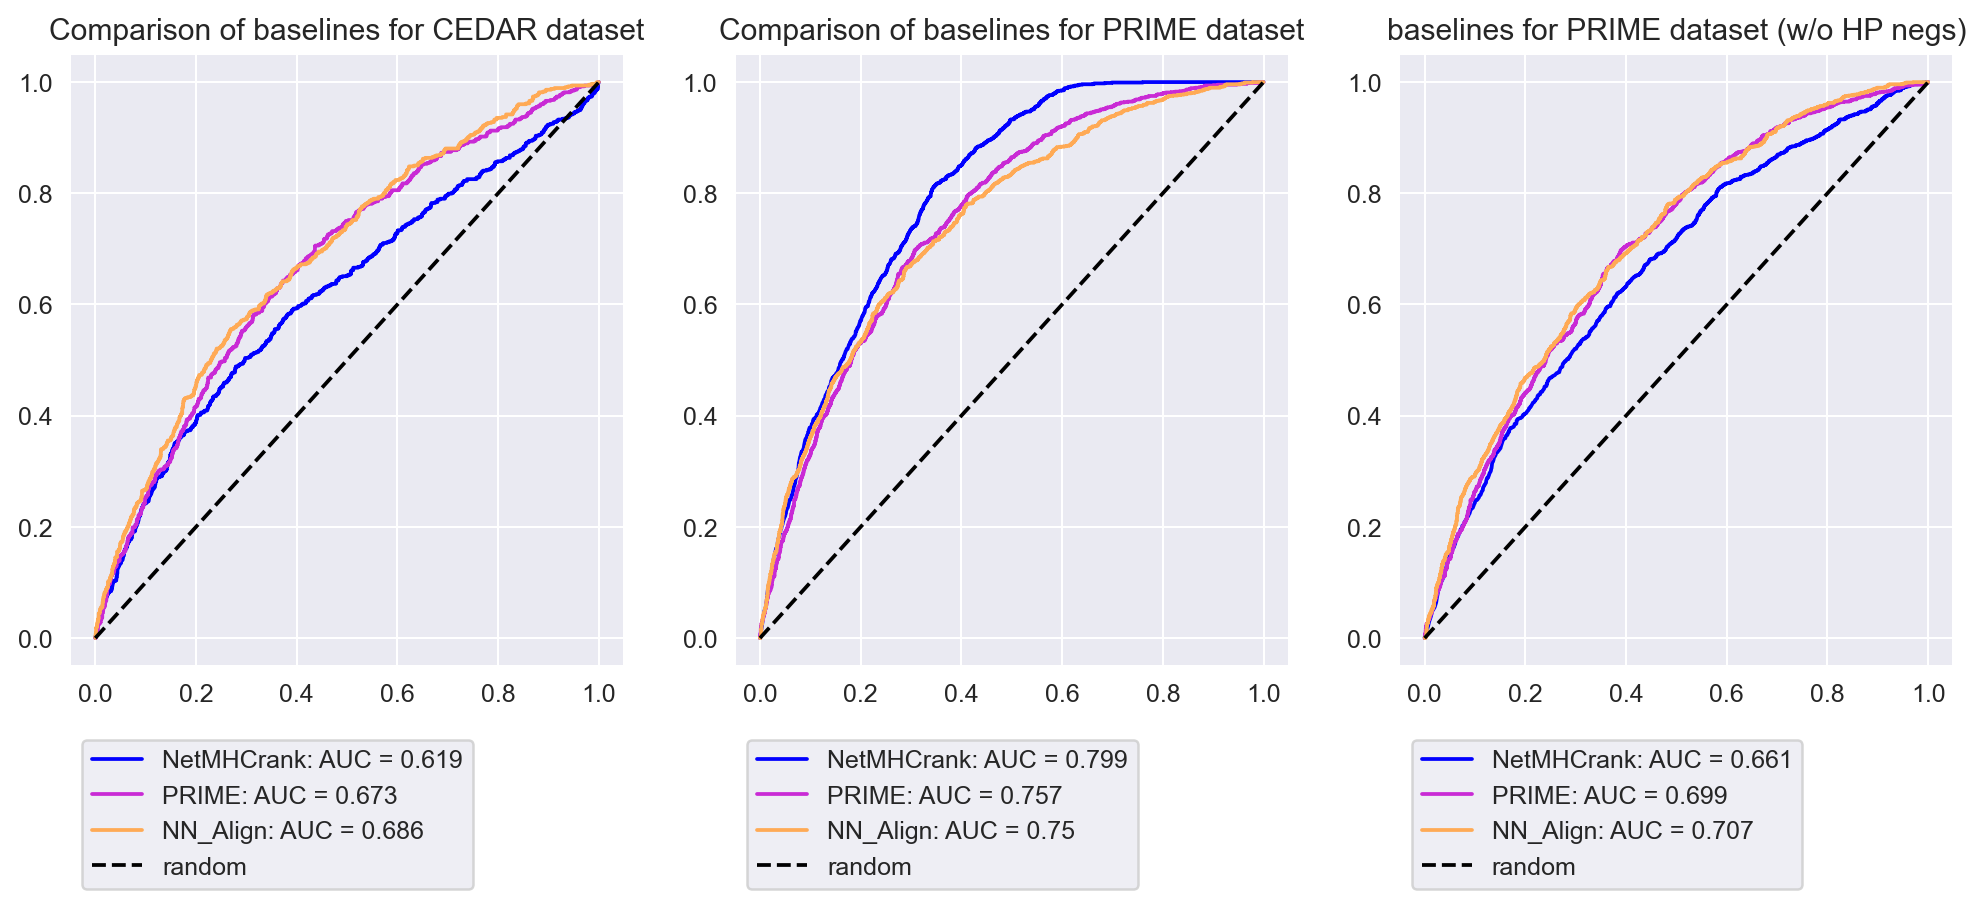

In [17]:
# For CEDAR
from sklearn.metrics import roc_auc_score, roc_curve
#FOR CEDAR
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)

sns.set_palette('gnuplot2', n_colors=3)
f,a = plt.subplots(1,3, figsize=(13.5,4.5))
a[0].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[0].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[0].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[0].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[0].legend(bbox_to_anchor=(0.75, -0.1))
a[0].set_title('Comparison of baselines for CEDAR dataset')
# FOR PRIME
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)

a[1].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[1].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[1].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[1].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[1].legend(bbox_to_anchor=(0.75, -0.1))
a[1].set_title('Comparison of baselines for PRIME dataset')


tmp = prime.query('StudyOrigin!="Random"')
fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
a[2].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[2].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[2].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[2].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[2].legend(bbox_to_anchor=(0.75, -0.1))
a[2].set_title('baselines for PRIME dataset (w/o HP negs)')

# Bootstrap

## fct defs

In [18]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score
# PLOT BASELINE FUNCTIONS
def plot_baseline_roc(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)
    elif dataset=='prime':
        
        tmp = prime.query('StudyOrigin != "Random"') if remove_hp else prime
        
        fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
    
    axis.plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}',
              linestyle='--', lw=0.75, color='m')
    axis.plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}',
              linestyle='--', lw=0.75, color='g')
    axis.plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}',
              linestyle='--', lw=0.75, color='c')

    
def plot_baseline_pr(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
        
    elif dataset=='prime':
        tmp = dataset.query('StudyOrigin != "Random"') if remove_hp else prime
        
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
    
    axis.plot(recall_netmhc, precision_netmhc, label = f'NetMHCrank: PRAUC = {round(prauc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(recall_prime, precision_prime, label = f'PRIME: PRAUC = {round(prauc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(recall_nnalign, precision_nnalign, label = f'NN_Align: PRAUC = {round(prauc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')



In [19]:
# BOOTSTRAP FUNCTIONS
from joblib import Parallel, delayed
from functools import partial
from src.metrics import get_metrics


def bootstrap_wrapper(y_score, y_true, seed):    
    np.random.seed(seed)
    sample_idx = np.random.randint(0, len(y_score), len(y_score))
    sample_score = y_score[sample_idx]
    sample_true = y_true[sample_idx]
    
    test_results = get_metrics(sample_true, sample_score)
    
    # Save to get mean curves after
    roc_curve = (test_results.pop('roc_curve'), test_results['auc'])
    # Same
    pr_curve = (test_results.pop('pr_curve'), test_results['prauc'])
    return pd.DataFrame(test_results, index=[0]), roc_curve 


def bootstrap_eval(y_score, y_true, n_rounds=10000, n_jobs=16):
    wrapper = partial(bootstrap_wrapper, 
                      y_score=y_score, y_true=y_true)
    print('Sampling')
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in tqdm(range(n_rounds), desc='Bootstrapping rounds', position=1))
    
    print('Making results DF and curves')
    result_df = pd.concat([x[0] for x in output])
    mean_roc_curve = get_mean_roc_curve([x[1] for x in output])
    # mean_pr_curve = get_mean_pr_curve([x[2] for x in output])
    return result_df, mean_roc_curve

def load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix=None, weight = None):
    outdict = {'trainset': train_dataset['trainset'].unique()[0],
                       'model': MAPPING[model.__class__.__name__],
                       'weight': weight} # Hardcoded here
        
    outdict.update({k: v for k, v in encoding_kwargs.items() if k != 'blosum_matrix'})
    
    if blosum_matrix is not None:
        bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
        outdict['blsm'] = bl_name
        
    outname = '_'.join([f'{k}{v}' for k, v in outdict.items() if k!='invert'])
    
    if blosum_matrix is not None:
        bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
        outdict['blsm'] = bl_name
        
    pkl_name = convert_path(os.path.join(f'../output/tuning/{MAPPING[model.__class__.__name__].lower()}_bootstrap', (outname + '.pkl')).replace('//', '/'))
    hyperparams = pkl_load(pkl_name)
    if 'max_depth' in hyperparams:
        if np.isnan(hyperparams['max_depth']):
            hyperparams['max_depth'] = None
        else:
    
            hyperparams['max_depth'] = int(hyperparams['max_depth'])
    
    for k in [x for x in hyperparams.keys() if x.startswith('n_')]:
        # converts n_estimators, n_layers, n_in, n_hidden, to int
        hyperparams[k] = int(hyperparams[k])
    return hyperparams

## Checking trainset - add_rank

### runs

In [71]:
all_results = {}
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': False,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
blosum_matrix = None

tmp_prime = prime_fold.query('StudyOrigin != "Random"')


# DICT with multiple levels: 1 for add_rank, 1 more for model, 1 more for train_dataset, 1 more for df/curve
# --> all_results['True']['XGB']['cedar']['df_prime'] to get the results of prime

for add_rank in [True, False]:
    encoding_kwargs.update({'add_rank':add_rank})
    # All results['True']
    all_results[str(add_rank)] = {}
    for model in [XGBClassifier(verbosity=0, method='gpu_hist', n_jobs=1, subsample=0.75), 
                  RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)]:
        # all_results['True']['XGB']
        all_results[str(add_rank)][MAPPING[model.__class__.__name__]] = {}
        
        for train_dataset in tqdm(
                                    [cedar,
                                     cedar_viral_old,
                                     cedar_viral_more,
                                     viral_only,
                                     prime_fold,
                                     cedar_hp_uni,
                                     cedar_hp_low
                                    ],
                                  desc = 'trainset', position=0):
            
            trainset_name = train_dataset.trainset.unique().item()
            # all_results['True']['XGB']['CEDAR'] = {}
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name] = {}
            # Reload params
            hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix)
            model.set_params(**hyperparams)
            
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=None,
                                                            encoding_kwargs=encoding_kwargs)
            # EVAL + BOOTSTRAP ON CEDAR TEST SET
            _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                          ics_dict=None, train_dataframe=train_dataset,
                                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                          concatenated=True, return_scores=True)
                
            results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                      y_true = concat_true, 
                                                      n_rounds=10000, n_jobs = 8)
            
            results_df['trainset'] = trainset_name
            results_df['model'] = MAPPING[model.__class__.__name__]
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['df_cedar'] = results_df
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['mean_rocs_cedar'] = mean_rocs
            # EVAL + BOOTSTRAP ON PRIME TEST SET
            _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                          ics_dict=None, train_dataframe=train_dataset,
                                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                          concatenated=True, return_scores=True)
            results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                      y_true = concat_true, 
                                                      n_rounds=10000, n_jobs = 8)
            results_df['trainset'] = trainset_name
            results_df['model'] = MAPPING[model.__class__.__name__]
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['df_prime'] = results_df
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['mean_rocs_prime'] = mean_rocs
            # results[trainset_name]['all_prs'] = all_prs
            
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['model'] = trained_models
pkl_dump(all_results, '../output/bootstrapping/trainset_models.pkl')

trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/bootstrapping/trainset_models.pkl saved.


In [72]:
df_rank_trainset_model_cedar = []
df_rank_trainset_model_prime = []

for add_rank in [True,False]:
    for model, value_model in all_results[str(add_rank)].items():
        for trainset, value_trainset in value_model.items():
            
            df_cedar = value_trainset['df_cedar']
            df_cedar['add_rank']=add_rank
            df_rank_trainset_model_cedar.append(df_cedar)
            
            df_prime = value_trainset['df_prime']
            df_prime['add_rank']=add_rank
            df_rank_trainset_model_prime.append(df_prime)
            
df_rank_trainset_model_cedar= pd.concat(df_rank_trainset_model_cedar)
df_rank_trainset_model_cedar.to_csv('../output/bootstrapping/df_rank_trainset_model_cedar.csv', index=False)
df_rank_trainset_model_prime= pd.concat(df_rank_trainset_model_prime)
df_rank_trainset_model_prime.to_csv('../output/bootstrapping/df_rank_trainset_model_prime.csv', index=False)

In [12]:
all_results = pkl_load('../output/bootstrapping/trainset_models.pkl')

In [13]:
df_rank_trainset_model_cedar = pd.read_csv('../output/bootstrapping/df_rank_trainset_model_cedar.csv')
df_rank_trainset_model_prime = pd.read_csv('../output/bootstrapping/df_rank_trainset_model_prime.csv')

### plots 

Text(0, 0.5, 'Test AUC (CEDAR)')

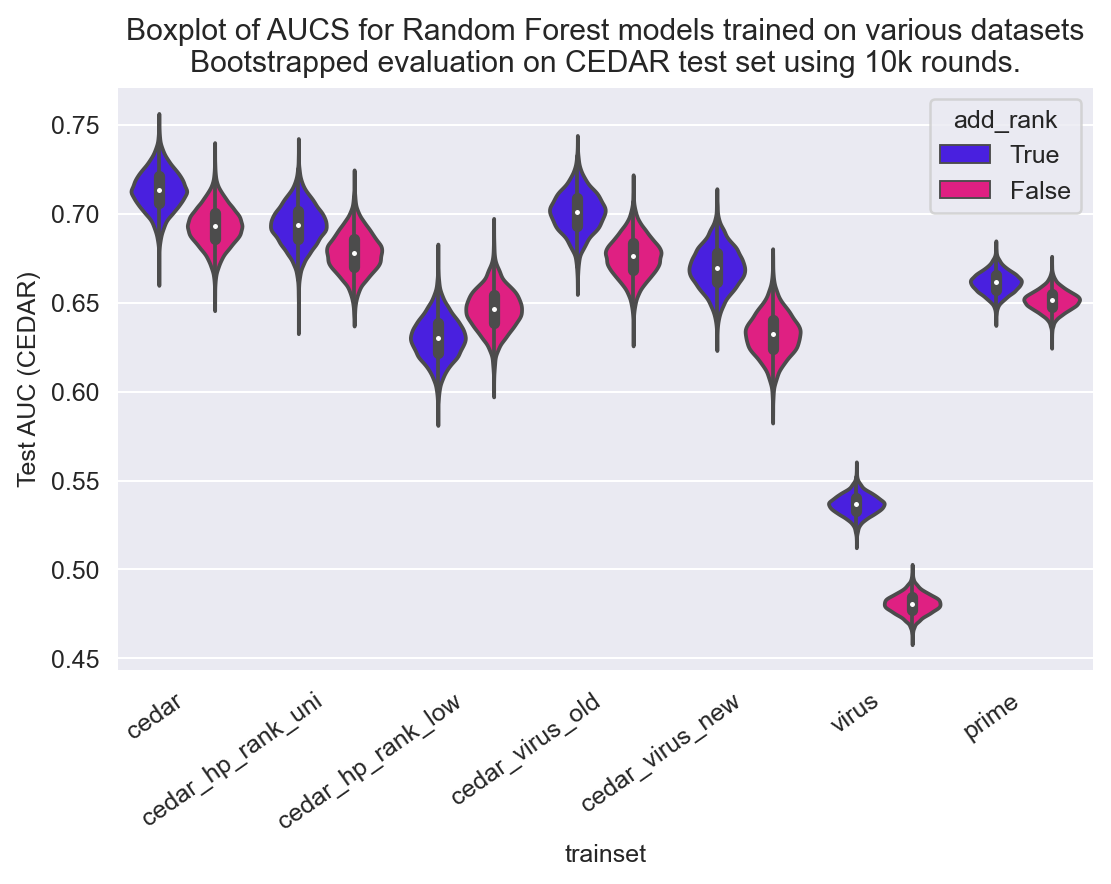

In [73]:
# Overall boxplot
f,a = plt.subplots(1,1, figsize=(7,4.3))
sns.set_palette([HSV[0], HSV[1]])
x_order = ['cedar', 'cedar_hp_rank_uni', 'cedar_hp_rank_low', 'cedar_virus_old', 'cedar_virus_new', 'virus', 'prime']
sns.violinplot(data=df_rank_trainset_model_cedar.query('model=="RF"'), ax=a, hue_order = [True, False],
            x='trainset', hue='add_rank', y='auc',
            order = x_order)
a.set_xticklabels(labels = x_order, rotation = 35, fontdict={'horizontalalignment':'right'})
a.set_title('Boxplot of AUCS for Random Forest models trained on various datasets\nBootstrapped evaluation on CEDAR test set using 10k rounds.')
a.set_ylabel('Test AUC (CEDAR)')

Text(0.5, 1.0, 'Bootstrapped AUC on CEDAR test set vs on PRIME test set\nFor different train sets\nUsing 10,000 rounds, RandomForest trained on amino-acid frequencies + %Rank')

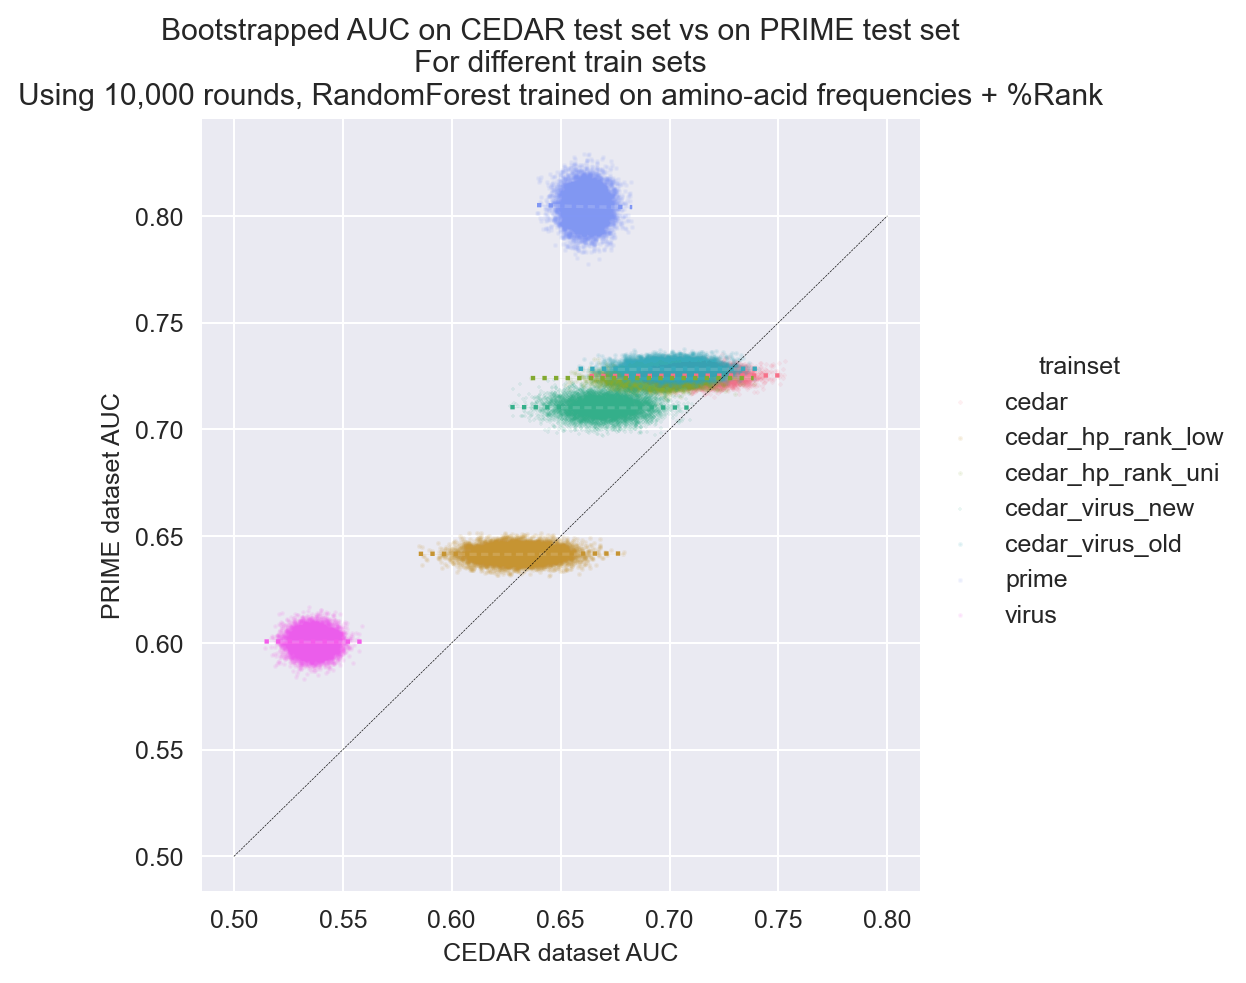

In [74]:
# X-Y lm plot
df_rank_trainset_concat = pd.merge(left=df_rank_trainset_model_cedar.rename(columns={'auc':'Score_CEDAR_AUC'})[['Score_CEDAR_AUC', 'trainset', 'model', 'add_rank']]\
                                                                .sort_values(['trainset','model','add_rank']).reset_index(drop=True),
                                    right=df_rank_trainset_model_prime.rename(columns={'auc':'Score_PRIME_AUC'})\
                                                                .sort_values(['trainset','model','add_rank']).reset_index(drop=True)['Score_PRIME_AUC'],
                                   left_index=True, right_index=True)


sns.set_palette(HSV)
f = plt.Figure(figsize=(7,7))

# f.set_axis_labels('CEDAR dataset AUC', 'PRIME dataset AUC')
sns.lmplot(data=df_rank_trainset_concat.query('add_rank==True and model=="RF"'),
           x='Score_CEDAR_AUC', y='Score_PRIME_AUC', hue='trainset',
           markers = ['x', 'o', '*', '+', '8', 's', 'p'], 
           scatter_kws={"alpha":0.1,"s":1}, line_kws={'lw':1.75,'ls':':'})

plt.plot([0.5,0.8],[0.5,.8], lw=0.25, ls='--', c='k')
plt.xlim = [0.55, 0.8]
plt.ylim = [0.55, 0.8]
plt.xlabel('CEDAR dataset AUC')
plt.ylabel('PRIME dataset AUC')

plt.title('Bootstrapped AUC on CEDAR test set vs on PRIME test set'\
           '\nFor different train sets'\
           '\nUsing 10,000 rounds, RandomForest trained on amino-acid frequencies + %Rank')

In [ ]:
# ROC PLOT
sns.set_palette(HSV, n_colors=7)
f,a = plt.subplots(1,1, figsize=(6,7.75), sharey=True)

for model in ['XGB', 'RF']:
    # RANK TRUE
    mean_cedar_roc = all_results[str(True)][model]['cedar']['mean_rocs_cedar']
    auc_01 =  all_results[str(True)][model]['cedar']['df_cedar']['auc_01'].mean()
    sns.lineplot(x=mean_cedar_roc[0],y=mean_cedar_roc[1], ax=a, 
                     label = f'{model} +%Rank={True}; AUC={round(mean_cedar_roc[4],3)}, AUC_01={round(auc_01,3)}', estimator=None)
    a.fill_between(np.linspace(0, 1, len(mean_cedar_roc[0])), mean_cedar_roc[2], mean_cedar_roc[3], alpha=0.15)
    # RANK FALSE
    mean_cedar_roc = all_results[str(False)][model]['cedar']['mean_rocs_cedar']
    auc_01 =  all_results[str(False)][model]['cedar']['df_cedar']['auc_01'].mean()
    sns.lineplot(x=mean_cedar_roc[0],y=mean_cedar_roc[1], ax=a, 
                     label = f'{model} +%Rank={False}; AUC={round(mean_cedar_roc[4],3)}, AUC_01={round(auc_01,3)}', estimator=None)
    a.fill_between(np.linspace(0, 1, len(mean_cedar_roc[0])), mean_cedar_roc[2], mean_cedar_roc[3], alpha=0.15)

a.plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')
# a.legend(bbox_to_anchor = (1.05, .67))#
a.set_ylim([-.025,1.025])
a.set_xlim([-.025,1.025])
plot_baseline_roc(axis=a, dataset='cedar')
a.legend(bbox_to_anchor= (.825, -.091))
f.tight_layout()
a.set_xlabel('FPR')
a.set_ylabel('TPR')
a.set_title('Comparison of ROCs for different methods and adding Rank, trained on CEDAR\n'\
           'Bootstrapped evaluation on CEDAR test set using 10k rounds.', fontweight='semibold', fontsize=14)


Text(0.5, 0.98, 'Comparison of models and effect of adding rank.\nWith p-values of one-sided T-tests (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds')

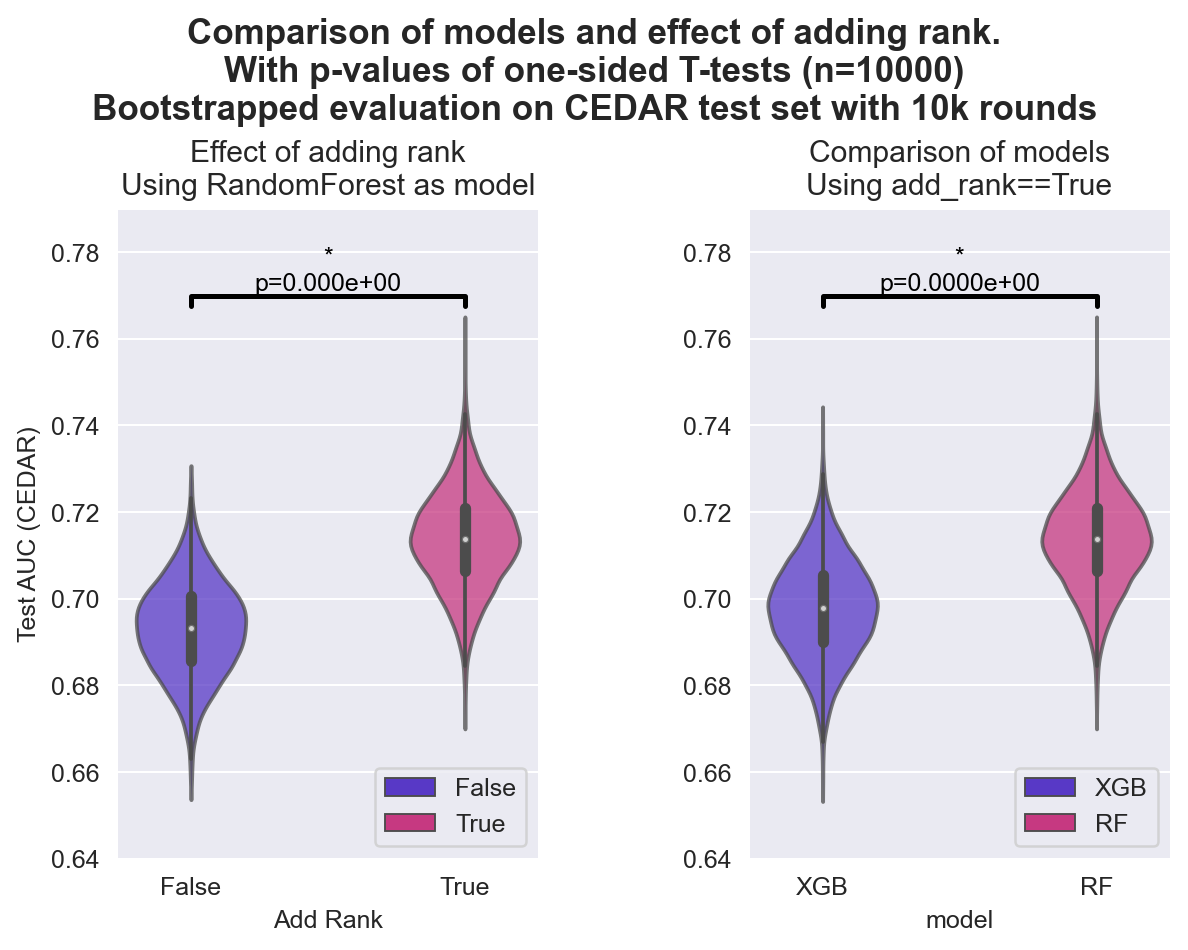

In [534]:
# LONE BOXPLOT WITH PVALUE
df_tmp = df_rank_trainset_model_cedar.query('trainset=="cedar" and model=="RF"').rename(columns={'auc':'CEDAR AUC',
                                                                                                 'add_rank': 'Add Rank'})
df_tmp2 = df_rank_trainset_model_cedar.query('trainset=="cedar" and add_rank==True').rename(columns={'auc':'CEDAR AUC'})
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

# FIRST (left boxplot to check Add Rank on CEDAR with pval)
sns.violinplot(data=df_tmp, x='Add Rank', y='CEDAR AUC', hue='Add Rank',  
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)

rank_true = df_tmp.query('`Add Rank`==True')['CEDAR AUC'].values
rank_false = df_tmp.query('`Add Rank`==False')['CEDAR AUC'].values
pval = ttest_ind(rank_true, rank_false, alternative='greater')[1]
label= f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Effect of adding rank\nUsing RandomForest as model')


# FIRST (left boxplot to check Add Rank on CEDAR with pval
sns.violinplot(data=df_tmp2, x='model', y='CEDAR AUC', hue='model',  
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
score_xgb = df_tmp2.query('model=="XGB"')['CEDAR AUC'].values
score_rf = df_tmp2.query('model=="RF"')['CEDAR AUC'].values
pval = ttest_ind(score_rf, score_xgb, alternative='greater')[1]
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns, p={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel(None)
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of models\nUsing add_rank==True')
# a.set_title(binder)
f.tight_layout(pad=5.75)
f.suptitle('Comparison of models and effect of adding rank.\nWith p-values of one-sided T-tests (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

### REDO the violin p-values
Need to re-do the p-values, using the division thing from Morten instead

In [59]:
# Need to: Train on CEDAR only, do RandomForest, XGBoost, +/- Rank.

all_results = {}
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  
                   'add_rank': False,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
blosum_matrix = None

tmp_prime = prime_fold.query('StudyOrigin != "Random"')


# DICT with multiple levels: 1 for add_rank, 1 more for model, 1 more for train_dataset, 1 more for df/curve
# --> all_results['True']['XGB']['cedar']['df_prime'] to get the results of prime
dfs = []
for add_rank in [True, False]:
    encoding_kwargs.update({'add_rank':add_rank})
    # All results['True']
    all_results[str(add_rank)] = {}
    for model in [XGBClassifier(verbosity=0, method='hist', n_jobs=1, subsample=0.75), 
                  RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)]:
        # all_results['True']['XGB']
        all_results[str(add_rank)][MAPPING[model.__class__.__name__]] = {}
        
        for train_dataset in tqdm(
                                    [cedar],
                                  desc = 'trainset', position=0):
            
            trainset_name = train_dataset.trainset.unique().item()
            # all_results['True']['XGB']['CEDAR'] = {}
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name] = {}
            # Reload params
            hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix)
            model.set_params(**hyperparams)
            
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=None,
                                                            encoding_kwargs=encoding_kwargs)
            # EVAL + BOOTSTRAP ON CEDAR TEST SET
            _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                          ics_dict=None, train_dataframe=train_dataset,
                                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                          concatenated=True, return_scores=True)
                
            results_df, mean_rocs  = bootstrap_eval(y_score = concat_pred,
                                                      y_true = concat_true, 
                                                      n_rounds=10000, n_jobs = 8)
            
            results_df['trainset'] = trainset_name
            results_df['model'] = MAPPING[model.__class__.__name__]
            results_df['add_rank'] = add_rank
            # all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['df_cedar'] = results_df
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['mean_rocs_cedar'] = mean_rocs
            dfs.append(results_df)
            


trainset:   0%|          | 0/1 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/1 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/1 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/1 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [60]:
df_rank_trainset_model_cedar = pd.concat(dfs)
df_rank_trainset_model_cedar.to_csv('../output/bootstrapping/df_pval_trainset_model_rank.csv')

Text(0.5, 0.98, 'Comparison of models and effect of adding rank.\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds')

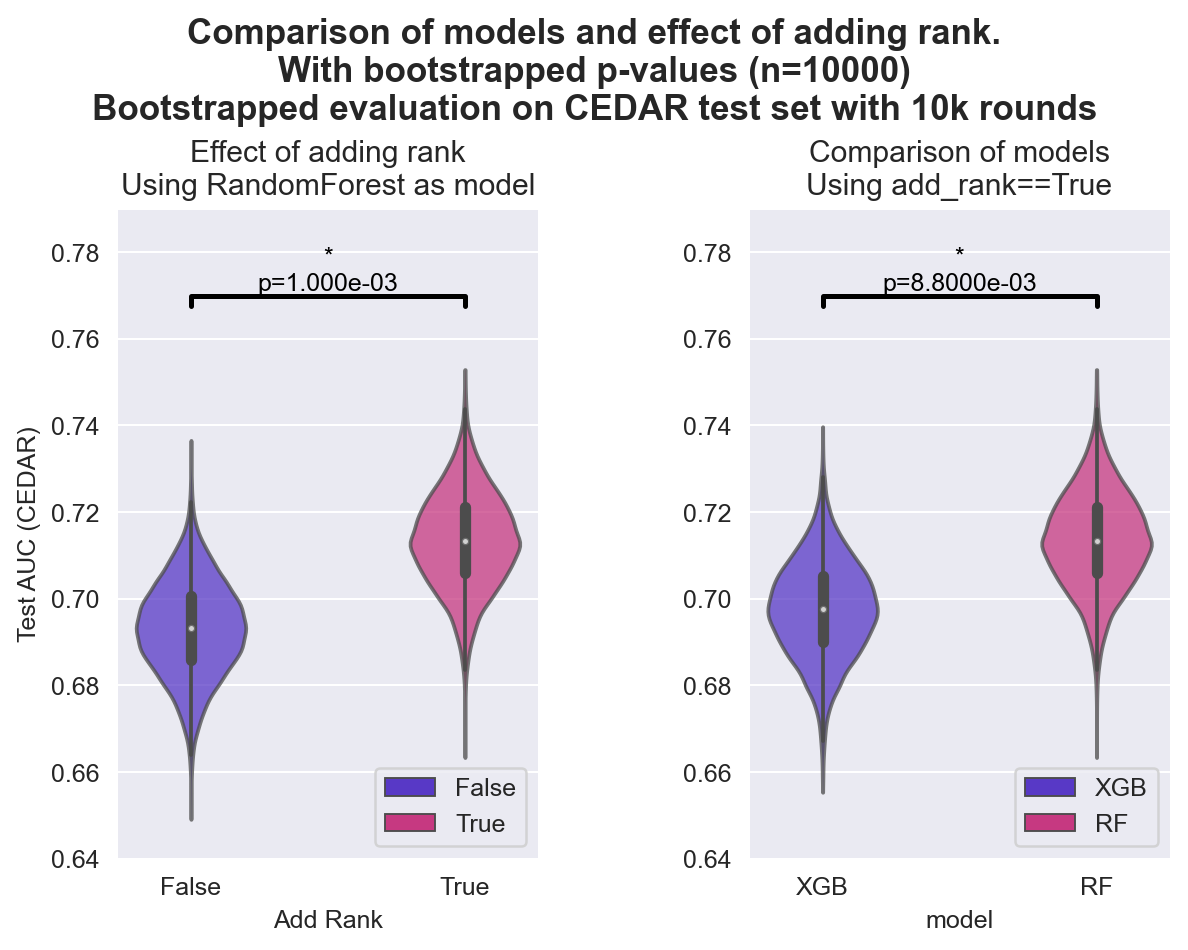

In [61]:
# LONE BOXPLOT WITH PVALUE
df_tmp = df_rank_trainset_model_cedar.query('trainset=="cedar" and model=="RF"').rename(columns={'auc':'CEDAR AUC',
                                                                                                 'add_rank': 'Add Rank'})
df_tmp2 = df_rank_trainset_model_cedar.query('trainset=="cedar" and add_rank==True').rename(columns={'auc':'CEDAR AUC'})
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

# FIRST (left boxplot to check Add Rank on CEDAR with pval)
sns.violinplot(data=df_tmp, x='Add Rank', y='CEDAR AUC', hue='Add Rank',  
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)

rank_true = df_tmp.query('`Add Rank`==True')['CEDAR AUC'].values
rank_false = df_tmp.query('`Add Rank`==False')['CEDAR AUC'].values
# pval = ttest_ind(rank_true, rank_false, alternative='greater')[1]
# New P-val calculation, 1 - M/N
pval = 1 - (len((rank_true>rank_false).astype(int).nonzero()[0]) / len(rank_true) )
label= f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Effect of adding rank\nUsing RandomForest as model')


# FIRST (left boxplot to check Add Rank on CEDAR with pval
sns.violinplot(data=df_tmp2, x='model', y='CEDAR AUC', hue='model',  
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
score_xgb = df_tmp2.query('model=="XGB"')['CEDAR AUC'].values
score_rf = df_tmp2.query('model=="RF"')['CEDAR AUC'].values

pval = 1 - (len((score_rf>score_xgb).astype(int).nonzero()[0]) / len(score_xgb) )
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns, p={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel(None)
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of models\nUsing add_rank==True')
# a.set_title(binder)
f.tight_layout(pad=5.75)
f.suptitle('Comparison of models and effect of adding rank.\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

## Checking Encoding & Weights

### runs

In [41]:
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
train_dataset = cedar
enc_weight_results = {}
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
tmp_prime = prime_fold.query('StudyOrigin != "Random"')
for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot','blosum', 'blosum'], 
                                              [None, BL62_VALUES, BL62FREQ_VALUES],
                                              ['onehot','BL62LO', 'BL62FREQ']),
                                              desc = 'encoding', leave=True, position=0):
    
    encoding_kwargs['encoding']=encoding
    encoding_kwargs['blosum_matrix']=blosum_matrix
    
    enc_weight_results[blsm_name] = {}
    
    for ic_name, ics_dict in tqdm(zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                                 desc = 'Weighting', leave=True, position=1):
        encoding_kwargs['mask'] = True if ic_name =='Mask' else False
        
        enc_weight_results[blsm_name][ic_name]={}        
        trainset_name = train_dataset.trainset.unique().item()
        ###################################################
        # THIS BLOCK IS COPIED FROM THE NESTED KCV SCRIPT #
        ###################################################
        hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
        model.set_params(**hyperparams)

        ###################################################
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                        encoding_kwargs=encoding_kwargs)
        ############EVAL CEDAR############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
            
        results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=50000, n_jobs = 8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_cedar.csv', index=False)
        enc_weight_results[blsm_name][ic_name]['df_cedar'] = results_df
        enc_weight_results[blsm_name][ic_name]['mean_rocs_cedar'] = mean_rocs
        
        ###########EVAL PRIME ############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
        results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=50000, n_jobs = 8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_prime.csv', index=False)
        enc_weight_results[blsm_name][ic_name]['df_prime'] = results_df
        enc_weight_results[blsm_name][ic_name]['mean_rocs_prime'] = mean_rocs
        
        enc_weight_results[blsm_name][ic_name]['model'] = trained_models
    

pkl_dump(enc_weight_results, '../output/bootstrapping/encoding_weighting.pkl')

encoding: 0it [00:00, ?it/s]

Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
../output/bootstrapping/encoding_weighting.pkl saved.


In [63]:
df_encoding_weight_cedar = []
df_encoding_weight_prime = []
for key_encoding, v1 in enc_weight_results.items():
    for key_weight, value_weight in v1.items():
        df_cedar = value_weight['df_cedar']
        # df_cedar['add_rank']=add_rank
        df_encoding_weight_cedar.append(df_cedar)
        
        df_prime = value_weight['df_prime']
        # df_prime['add_rank']=add_rank
        df_encoding_weight_prime.append(df_prime)
        
df_encoding_weight_cedar= pd.concat(df_encoding_weight_cedar)
df_encoding_weight_cedar.to_csv('../output/bootstrapping/df_encoding_weight_cedar_rankTrue_modelRF_trainsetcedar.csv', index=False)
df_encoding_weight_prime= pd.concat(df_encoding_weight_prime)
df_encoding_weight_prime.to_csv('../output/bootstrapping/df_encoding_weight_prime_rankTrue_modelRF_trainsetcedar.csv', index=False)

### plots

In [47]:
enc_weight_results = pkl_load('../output/bootstrapping/encoding_weighting.pkl')

Text(0, 0.5, 'Test AUC (CEDAR)')

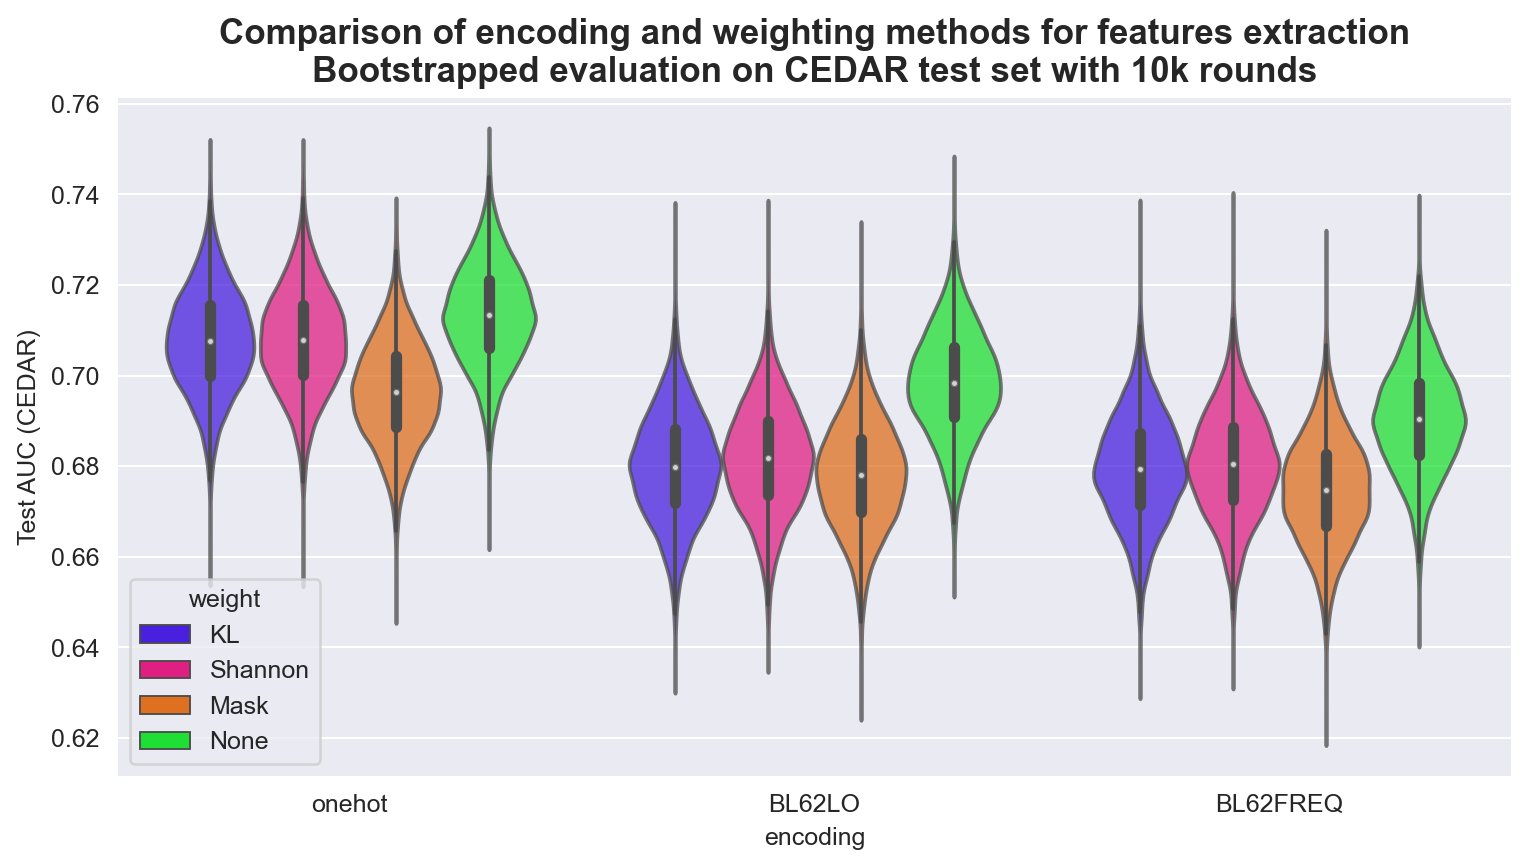

In [78]:
# VIOLINPLOTS WITHOUT PRIME
f,a = plt.subplots(1,1, figsize=(10,5))
sns.set_palette(HSV)
sns.violinplot(data= df_encoding_weight_cedar, x = 'encoding', hue='weight', y = 'auc', cut=1,
               dodge=True, width=.8, ax=a, hue_order = ['KL', 'Shannon', 'Mask', 'None'])
plt.setp(a.collections, alpha=.75)
a.set_title('Comparison of encoding and weighting methods for features extraction\nBootstrapped evaluation on CEDAR test set with 10k rounds',
           fontweight='semibold', fontsize=14)
a.set_ylabel('Test AUC (CEDAR)')
 

In [79]:
df_encoding_weight_cedar.groupby(['encoding', 'weight']).agg(mean_cedar_auc = ('auc', 'mean'),
                                                             max_cedar_auc = ('auc', 'max'),
                                                             std_cedar_auc = ('auc', 'std')).sort_values('mean_cedar_auc', ascending=False)

mean_cedar_auc  max_cedar_auc  std_cedar_auc
encoding weight                                               
onehot   None           0.713448       0.752886       0.011204
         Shannon        0.707796       0.750278       0.011494
         KL             0.707674       0.750302       0.011448
BL62LO   None           0.698397       0.746582       0.011786
onehot   Mask           0.696443       0.737424       0.011337
BL62FREQ None           0.690418       0.737941       0.011867
BL62LO   Shannon        0.681687       0.736812       0.011970
BL62FREQ Shannon        0.680474       0.738529       0.011840
BL62LO   KL             0.679898       0.736311       0.011977
BL62FREQ KL             0.679440       0.736858       0.011876
BL62LO   Mask           0.677896       0.732098       0.011850
BL62FREQ Mask           0.674728       0.730218       0.011768

Text(0.5, 0.98, 'Comparison of top two methods (OneHot-encoding and Shannon/None weight)\nWith p-values of one-sided T-tests (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds')

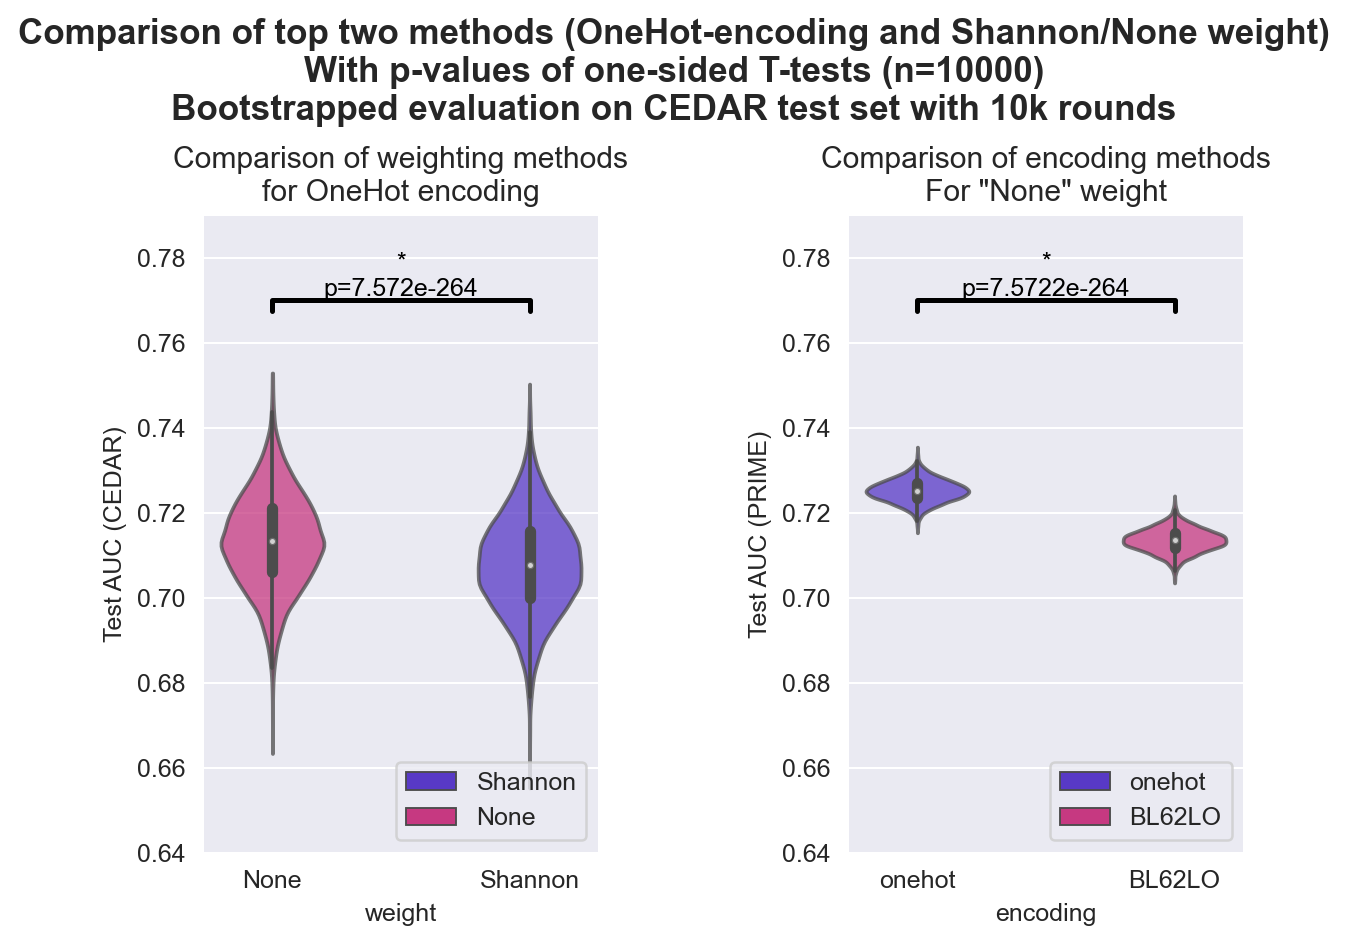

In [80]:
# LONE BOXPLOT WITH PVALUE 
# Comparing Onehot-None vs Onehot-Shannon (Shannon has a bigger max but lower mean)
df_tmp = df_encoding_weight_cedar.query('encoding=="onehot" and weight in ["Shannon", "None"]')
df_tmp2 = df_encoding_weight_prime.query('encoding in ["onehot", "BL62LO"] and weight in ["None"]')

sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

#############################################################
# FIRST (left boxplot to check Add Rank on CEDAR with pval) #
#############################################################

sns.violinplot(data=df_tmp, x='weight', y='auc', hue='weight', hue_order = ['Shannon', 'None'],
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)
# PVALUES
df_shannon = df_tmp.query('weight=="Shannon"')['auc'].values
# df_kl = df_tmp.query('weight=="Shannon"')['auc'].values
df_none = df_tmp.query('weight=="None"')['auc'].values
pval = ttest_ind(df_none, df_shannon, alternative='greater')[1]
# pval_shannon_kl = ttest_ind(df_shannon, df_kl, alternative='greater')[1]
label = f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# label_shannon_kl = f'*\np={pval_shannon_kl:.3e}' if pval<0.025 else f'ns, p={pval_shannon_kl:.3f}'

# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Comparison of weighting methods\nfor OneHot encoding')


#############################################################
#                          2ND                              #
#############################################################
sns.violinplot(data=df_tmp2, x='encoding', y='auc', hue='encoding', hue_order = ['onehot', 'BL62LO'],
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
df_shannon = df_tmp2.query('encoding=="onehot"')['auc'].values
df_none = df_tmp2.query('encoding=="BL62LO"')['auc'].values
pval_shannon_none = ttest_ind(df_none, df_shannon, alternative='greater')[1]
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns, p={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel('Test AUC (PRIME)')
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of encoding methods\nFor "None" weight')
# a.set_title(binder)
f.tight_layout(pad=6)
f.suptitle('Comparison of top two methods (OneHot-encoding and Shannon/None weight)\nWith p-values of one-sided T-tests (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

Text(0.5, 1.0, 'Comparison of ROCs for the top two Weight-Encoding pair\nBootstrapped evaluation on CEDAR test set using 10k rounds.')

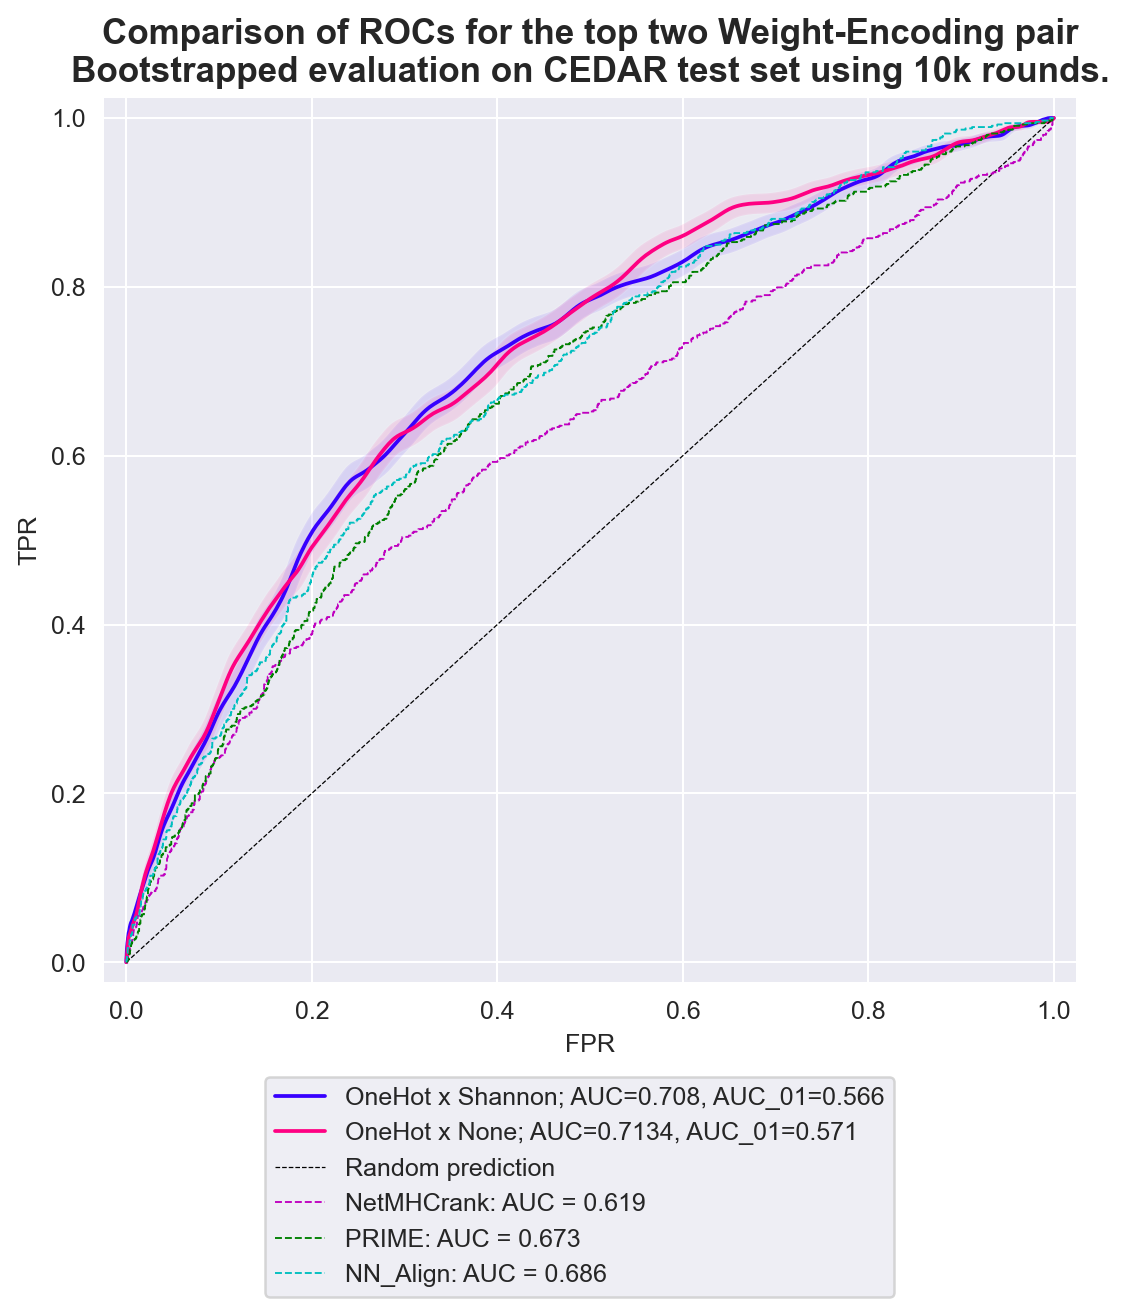

In [81]:
shannon_roc = enc_weight_results['onehot']['Shannon']['mean_rocs_cedar']
shannon_auc01 = enc_weight_results['onehot']['Shannon']['df_cedar']['auc_01'].mean()
none_roc = enc_weight_results['onehot']['None']['mean_rocs_cedar']
none_auc01 = enc_weight_results['onehot']['None']['df_cedar']['auc_01'].mean()
# ROC PLOT
sns.set_palette(HSV)
f,a = plt.subplots(1,1, figsize=(6,7.), sharey=True)

sns.lineplot(x=shannon_roc[0],y=shannon_roc[1], ax=a, 
                 label = f'OneHot x Shannon; AUC={round(shannon_roc[4],3)}, AUC_01={round(shannon_auc01,3)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(shannon_roc[0])), shannon_roc[2], shannon_roc[3], alpha=0.1)
    
sns.lineplot(x=none_roc[0],y=none_roc[1], ax=a, 
                 label = f'OneHot x None; AUC={round(none_roc[4],4)}, AUC_01={round(none_auc01,3)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(none_roc[0])), none_roc[2], none_roc[3], alpha=0.1)

a.plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')
# a.legend(bbox_to_anchor = (1.05, .67))#
a.set_ylim([-.025,1.025])
a.set_xlim([-.025,1.025])
plot_baseline_roc(axis=a, dataset='cedar')
a.legend(bbox_to_anchor= (.825, -.091))
f.tight_layout()
a.set_xlabel('FPR')
a.set_ylabel('TPR')
a.set_title('Comparison of ROCs for the top two Weight-Encoding pair\n'\
           'Bootstrapped evaluation on CEDAR test set using 10k rounds.', fontweight='semibold', fontsize=14)


### Here need to redo the pvalue thing again

In [62]:
# REDO SELECTED RUNS: (OneHot x [Shannon vs None], None x [OneHot vs BL62LO])
# --> OneHot-Shannon, OneHot-None, None-BL62LO
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
train_dataset = cedar
dfs = []
# RERUN BOOTSTRAP FOR PVALUE COMP
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
for encoding, blosum_matrix, blsm_name, ic_name, ics_dict in tqdm(zip(['onehot', 'blosum', 'onehot'], 
                                                                      [None, BL62_VALUES, None],
                                                                      ['onehot', 'BL62LO', 'onehot'],
                                                                      ['Shannon',  'None', 'None'],
                                                                      [ics_shannon,  None, None]),
                                              desc = 'encoding', leave=True, position=0):
    
    encoding_kwargs['encoding']=encoding
    encoding_kwargs['blosum_matrix']=blosum_matrix
    hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
    model.set_params(**hyperparams)
    ###################################################
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                    encoding_kwargs=encoding_kwargs)
    ############   EVAL CEDAR   ############
    _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                  ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                  train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                  concatenated=True, return_scores=True)

    results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                              y_true = concat_true, 
                                              n_rounds=10000, n_jobs = 8)

    results_df['model'] = MAPPING[model.__class__.__name__]
    results_df['encoding'] = blsm_name
    results_df['weight'] = ic_name
    dfs.append(results_df)
    # enc_weight_results[blsm_name][ic_name]['df_cedar'] = results_df
    # enc_weight_results[blsm_name][ic_name]['mean_rocs_cedar'] = mean_rocs


encoding: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [63]:
df_encoding_weight_cedar = pd.concat(dfs)
df_encoding_weight_cedar.to_csv('../output/bootstrapping/df_pval_redo_encoding_weight.csv')
df_tmp = df_encoding_weight_cedar.query('encoding=="onehot" and weight in ["Shannon", "None"]')
df_tmp2 = df_encoding_weight_cedar.query('encoding in ["onehot", "BL62LO"] and weight in ["None"]')



Text(0.5, 0.98, 'Comparison of top two methods (OneHot-encoding and Shannon/None weight)\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds')

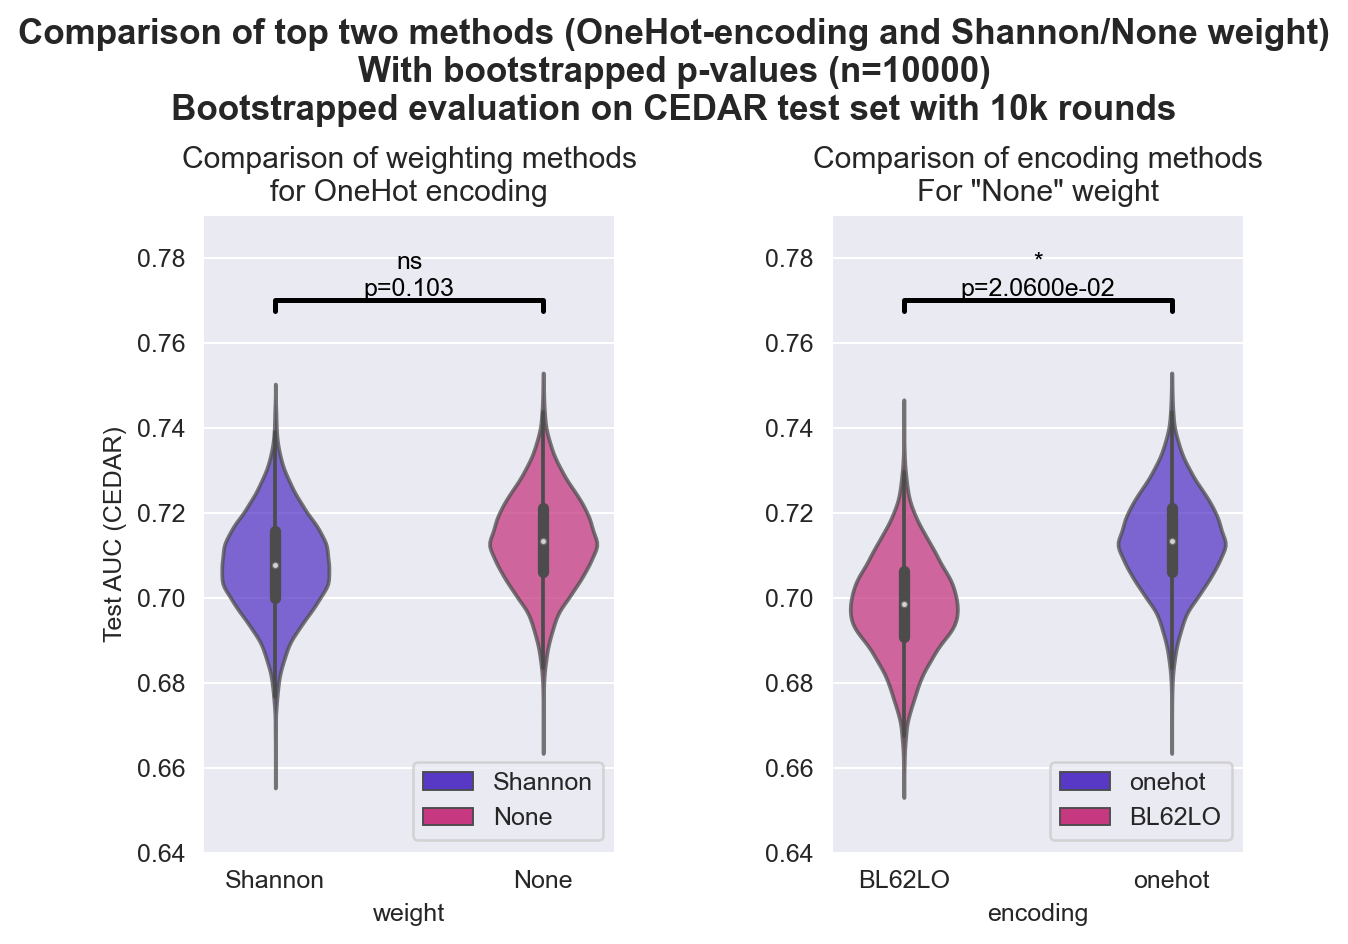

In [66]:
# LONE BOXPLOT WITH PVALUE 
# Comparing Onehot-None vs Onehot-Shannon (Shannon has a bigger max but lower mean)
df_tmp = df_encoding_weight_cedar.query('encoding=="onehot" and weight in ["Shannon", "None"]')
df_tmp2 = df_encoding_weight_cedar.query('encoding in ["onehot", "BL62LO"] and weight in ["None"]')

sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

#############################################################
# FIRST (left boxplot to check Add Rank on CEDAR with pval) #
#############################################################

sns.violinplot(data=df_tmp, x='weight', y='auc', hue='weight', hue_order = ['Shannon', 'None'],
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)
# PVALUES
df_shannon = df_tmp.query('weight=="Shannon"')['auc'].values
df_none = df_tmp.query('weight=="None"')['auc'].values

pval = 1 - (len((df_none>df_shannon).astype(int).nonzero()[0]) / len(df_shannon) )
label = f'*\np={pval:.3e}' if pval<0.025 else f'ns\np={pval:.3f}'

# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Comparison of weighting methods\nfor OneHot encoding')


#############################################################
#                          2ND                              #
#############################################################
sns.violinplot(data=df_tmp2, x='encoding', y='auc', hue='encoding', hue_order = ['onehot', 'BL62LO'],
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
df_onehot = df_tmp2.query('encoding=="onehot"')['auc'].values
df_blosum = df_tmp2.query('encoding=="BL62LO"')['auc'].values
pval = 1 - (len((df_onehot>df_blosum).astype(int).nonzero()[0]) / len(df_blosum) )
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns\np={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel(None)
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of encoding methods\nFor "None" weight')
# a.set_title(binder)
f.tight_layout(pad=6)
f.suptitle('Comparison of top two methods (OneHot-encoding and Shannon/None weight)\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

## check PC props

In [83]:
combo = zip([True, True, False, False, True],
            [True, False, True, False, True],
            [False, False, False, False, True])

encoding_kwargs = {'max_len':12, 
                   'encoding':'onehot',
                   'blosum_matrix':None,
                   'mask': False,
                   'mask':None,
                   'add_rank':None,
                   'add_aaprop':None,
                   'remove_pep':None,
                   'standardize':True}

train_dataset = cedar
model=RandomForestClassifier(n_jobs=15, min_samples_leaf=7)
tmp_prime = prime_fold.query('StudyOrigin!="Random"')
trainset_name = 'cedar'
for ic_name, ics_dict in tqdm(zip(['Shannon'], [ics_shannon]),
                                 desc = 'Weighting', leave=True, position=1):
    for add_rank, add_aaprop, remove_pep in combo:
        res = {}
        res['ic_name'] = ic_name
        res['add_rank'] = add_rank
        res['add_aaprop'] = add_aaprop
        res['remove_pep'] = remove_pep
        encoding_kwargs['mask'] = True if ic_name=='Mask' else False
        encoding_kwargs['add_rank'] = add_rank
        encoding_kwargs['add_aaprop'] = add_aaprop
        encoding_kwargs['remove_pep'] = remove_pep
        encoding_kwargs.update({'standardize':True})
        if not remove_pep:
            hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
        model.set_params(**hyperparams)

        ###################################################
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                        encoding_kwargs=encoding_kwargs)
        ############EVAL CEDAR############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
            
        results_df, mean_rocs= bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=10000, n_jobs =8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df['add_rank'] = add_rank
        results_df['add_aaprop'] = add_aaprop
        results_df['remove_pep'] = remove_pep
        res['cedar_df'] = results_df
        res['cedar_rocs'] = mean_rocs
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_rank{add_rank}_aaprop{add_aaprop}_remove_pep{remove_pep}_cedar.csv', index=False)
        
        ## PRIME
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
            
        results_df, mean_rocs= bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=10000, n_jobs = 8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df['add_rank'] = add_rank
        results_df['add_aaprop'] = add_aaprop
        results_df['remove_pep'] = remove_pep
        res['prime_df'] = results_df
        res['prime_rocs'] = mean_rocs
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_rank{add_rank}_aaprop{add_aaprop}_remove_pep{remove_pep}_prime.csv', index=False)
        features_results.append(res)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 67)

In [ ]:
features_df_cedar = pd.concat([x['cedar_df'] for x in features_results])
features_df_prime = pd.concat([x['prime_df'] for x in features_results])
features_df_cedar['encoding']='onehot'
features_df_prime['encoding']='onehot'

In [ ]:
pkl_dump(features_results, 'features_results.pkl', '../output/bootstrapping')

In [ ]:
mapname={'TrueTrueFalse': 'Base features + %Rank and PC props',
         'TrueFalseFalse': 'Base features + %Rank',
         'FalseTrueFalse': 'Base features + PC props',
         'FalseFalseFalse': 'Base features only',
         'TrueTrueTrue': 'Rank & PC props only'}

        
features_df_cedar['Features'] = features_df_cedar.apply(lambda x: mapname[str(x['add_rank'])+str(x['add_aaprop'])+str(x['remove_pep'])], axis=1)

In [ ]:
sns.set_palette(HSV+[sns.color_palette('hsv',n_colors=16)[8]])
f,a = plt.subplots(1,1, figsize=(9,5))

# hue_order = features_df_cedar.groupby(by=["Features"])["auc"].median().sort_values(ascending=False).index
hue_order = ['Base features + %Rank and PC props', 'Base features + %Rank',
'Base features only', 'Base features + PC props',  'Rank & PC props only']
sns.violinplot(data=features_df_cedar, x = 'weight', y='auc', hue = 'Features',
            order = ['KL', 'Shannon', 'Mask', 'None'], hue_order = hue_order)
plt.setp(a.collections, alpha=.735)
a.legend(bbox_to_anchor = (.725, -.1))
a.set_ylabel('Test AUC (CEDAR)')
a.set_title('Comparison of different types of features used\nWith OneHot encoding and various weighting schemes', fontweight='semibold', fontsize=14)

## Feature importances

In [427]:
encoding_kwargs= {'max_len': 12,
                  'encoding': 'onehot',
                  'blosum_matrix': None,
                  'mask': False,
                  'add_rank': True,
                  'add_aaprop': False,
                  'remove_pep': False,
                  'standardize': True}
trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=None, encoding_kwargs=encoding_kwargs)

encoding_kwargs= {'max_len': 12,
                  'encoding': 'onehot',
                  'blosum_matrix': None,
                  'mask': False,
                  'add_rank': True,
                  'add_aaprop': False,
                  'remove_pep': False,
                  'standardize': True}
trained_models2, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_shannon, encoding_kwargs=encoding_kwargs)


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [430]:
encoding_kwargs= {'max_len': 12,
                  'encoding': 'onehot',
                  'blosum_matrix': None,
                  'mask': False,
                  'add_rank': False,
                  'add_aaprop': False,
                  'remove_pep': False,
                  'standardize': True}
trained_models3, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_shannon, encoding_kwargs=encoding_kwargs)


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [449]:
feat_imps = []
feat_imps_shannon = []
feat_imps_norank_shannon = []

for k in trained_models.keys():
    mean_fi = np.mean([x.feature_importances_ for x in trained_models[k]], axis=0)
    mean_fi_shannon = np.mean([x.feature_importances_ for x in trained_models2[k]], axis=0)
    mean_fi_shannon_norank = np.mean([x.feature_importances_ for x in trained_models3[k]], axis=0)
    feat_imps.append(mean_fi)
    feat_imps_shannon.append(mean_fi_shannon)
    feat_imps_norank_shannon.append(mean_fi_shannon_norank)
    
mean_feat_imps= np.mean(np.stack(feat_imps), axis=0)
sd_feat_imps = np.std(np.stack(feat_imps), axis=0)
mean_feat_imps_shannon= np.mean(np.stack(feat_imps_shannon), axis=0)
sd_feat_imps_shannon = np.std(np.stack(feat_imps_shannon), axis=0)
mean_feat_imps_norank_shannon= np.mean(np.stack(feat_imps_norank_shannon), axis=0)
sd_feat_imps_norank_shannon = np.std(np.stack(feat_imps_norank_shannon), axis=0)

In [617]:
def plot_feature_importance(importance, names, title=''):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    f,a=plt.subplots(1,1, figsize=(7,6))
    sns.set_palette('viridis')
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],
                ax = a, palette='viridis_r')
    #Add chart labels
    # plt.title(model_type + 'FEATURE IMPORTANCE')
    # plt.xlabel('FEATURE IMPORTANCE')
    # plt.ylabel('FEATURE NAMES')
    plt.xticks(a.get_xticks(), (a.get_xticks()*100).round(1))
    plt.xlabel('Percentage importance [%]', fontsize=12)
    plt.ylabel('Feature name', fontsize=12)
    if title != '':
        a.set_title(title, fontweight='semibold', fontsize=14)
    return f,a

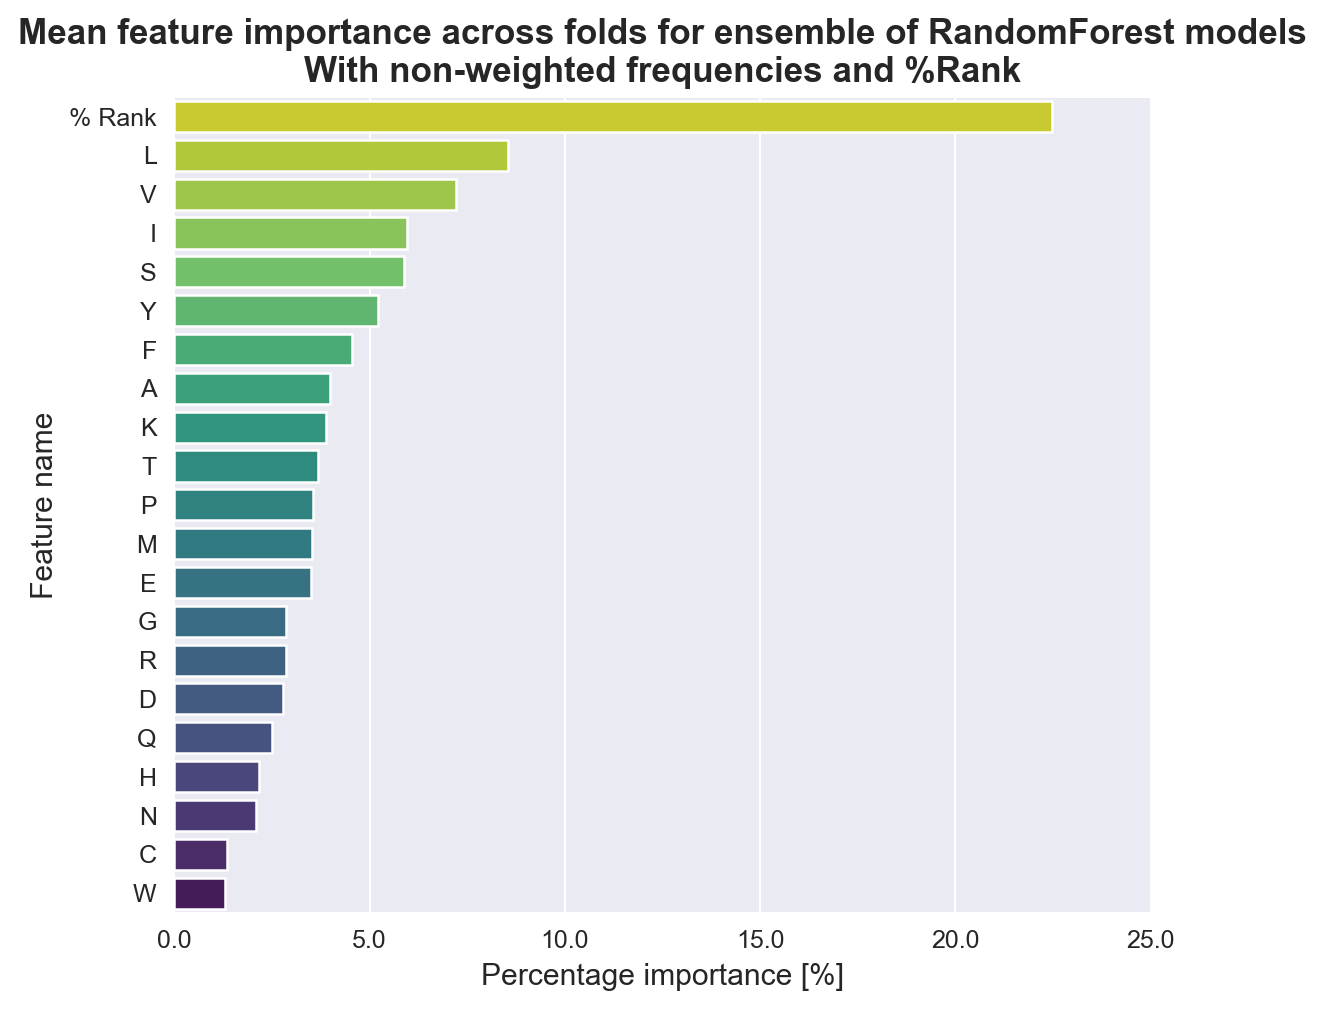

In [619]:
f,a  =plot_feature_importance(mean_feat_imps, AA_KEYS+['% Rank'], 'Mean feature importance across folds for ensemble of RandomForest models\nWith non-weighted frequencies and %Rank')

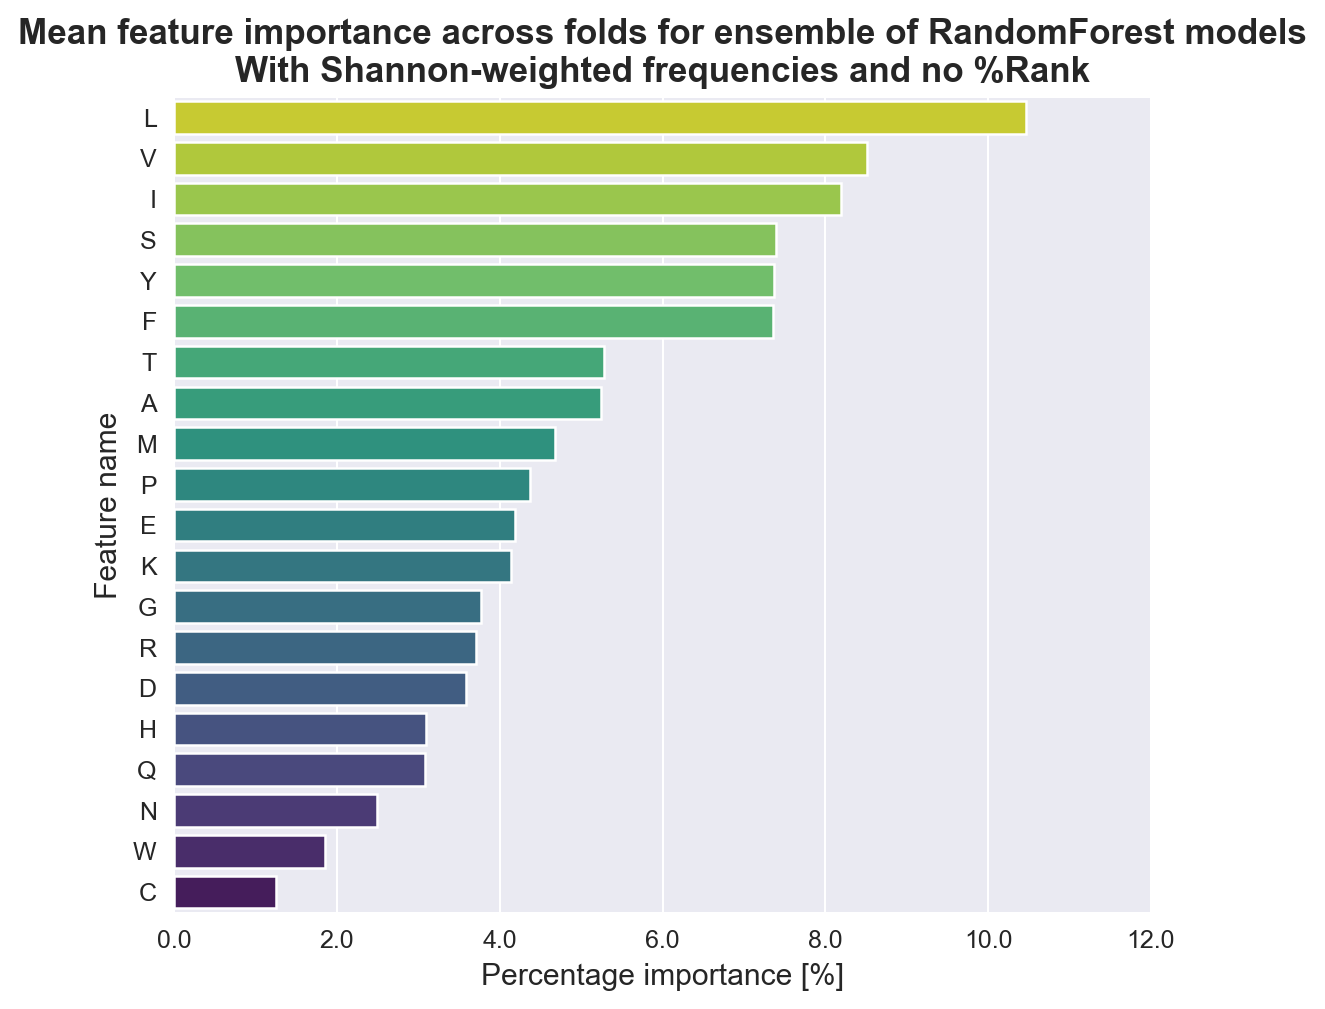

In [620]:
f,a  =plot_feature_importance(mean_feat_imps_norank_shannon, AA_KEYS, 'Mean feature importance across folds for ensemble of RandomForest models\nWith Shannon-weighted frequencies and no %Rank')

## CHECK INVERSE WEIGHTING

### runs

In [42]:
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  
                   'invert':True, # HERE INVERT !
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

train_dataset = cedar
inverted_enc_weight_results = {}
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
tmp_prime = prime_fold.query('StudyOrigin != "Random"')
for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot','blosum', 'blosum'], 
                                              [None, BL62_VALUES, BL62FREQ_VALUES],
                                              ['onehot','BL62LO', 'BL62FREQ']),
                                              desc = 'encoding', leave=True, position=0):
    
    encoding_kwargs['encoding']=encoding
    encoding_kwargs['blosum_matrix']=blosum_matrix
    
    inverted_enc_weight_results[blsm_name] = {}
    
    for ic_name, ics_dict in tqdm(zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                                 desc = 'Weighting', leave=True, position=1):
        encoding_kwargs['mask'] = True if ic_name =='Mask' else False
        
        inverted_enc_weight_results[blsm_name][ic_name]={}        
        trainset_name = train_dataset.trainset.unique().item()
        ###################################################
        # THIS BLOCK IS COPIED FROM THE NESTED KCV SCRIPT #
        ###################################################
        hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
        model.set_params(**hyperparams)

        ###################################################
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                        encoding_kwargs=encoding_kwargs)
        ############EVAL CEDAR############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
            
        results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=50000, n_jobs = 8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_inverted_cedar.csv', index=False)
        inverted_enc_weight_results[blsm_name][ic_name]['df_cedar'] = results_df
        inverted_enc_weight_results[blsm_name][ic_name]['mean_rocs_cedar'] = mean_rocs
        
        ###########EVAL PRIME ############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
        results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=50000, n_jobs = 8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_inverted_prime.csv', index=False)
        inverted_enc_weight_results[blsm_name][ic_name]['df_prime'] = results_df
        inverted_enc_weight_results[blsm_name][ic_name]['mean_rocs_prime'] = mean_rocs
        
        inverted_enc_weight_results[blsm_name][ic_name]['model'] = trained_models
    

pkl_dump(inverted_enc_weight_results, '../output/bootstrapping/inverted_encoding_weighting.pkl')

encoding: 0it [00:00, ?it/s]

Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/50000 [00:00<?, ?it/s]

Making results DF and curves
../output/bootstrapping/inverted_encoding_weighting.pkl saved.


### save/checks

In [43]:
df_inverted_encoding_weight_cedar = []
df_inverted_encoding_weight_prime = []
for key_encoding, v1 in inverted_enc_weight_results.items():
    for key_weight, value_weight in v1.items():
        df_cedar = value_weight['df_cedar']
        # df_cedar['add_rank']=add_rank
        df_inverted_encoding_weight_cedar.append(df_cedar)
        
        df_prime = value_weight['df_prime']
        # df_prime['add_rank']=add_rank
        df_inverted_encoding_weight_prime.append(df_prime)
        
df_inverted_encoding_weight_cedar= pd.concat(df_inverted_encoding_weight_cedar)
df_inverted_encoding_weight_cedar.to_csv('../output/bootstrapping/df_inverted_encoding_weight_cedar_rankTrue_modelRF_trainsetcedar.csv', index=False)
df_inverted_encoding_weight_prime= pd.concat(df_inverted_encoding_weight_prime)
df_inverted_encoding_weight_prime.to_csv('../output/bootstrapping/df_inverted_encoding_weight_prime_rankTrue_modelRF_trainsetcedar.csv', index=False)

In [44]:
df_encoding_weight_prime = pd.read_csv('../output/bootstrapping/df_encoding_weight_prime_rankTrue_modelRF_trainsetcedar.csv')
df_inverted_encoding_weight_prime['weight'] = df_inverted_encoding_weight_prime['weight'].apply(lambda x: 'Inverted '+x)
df_all_weight_prime = pd.concat([df_encoding_weight_prime, df_inverted_encoding_weight_prime.query('weight != "Inverted None"')])
df_all_weight_prime.to_csv('../output/bootstrapping/df_all_weight_prime.csv', index=False)

In [65]:
df_all_weight = pd.concat([df_encoding_weight_cedar, df_inverted_encoding_weight_cedar])


In [46]:
df_encoding_weight_cedar = pd.read_csv('../output/bootstrapping/df_encoding_weight_cedar_rankTrue_modelRF_trainsetcedar.csv')
df_inverted_encoding_weight_cedar['weight'] = df_inverted_encoding_weight_cedar['weight'].apply(lambda x: 'Inverted '+x)

df_all_weight = pd.concat([df_encoding_weight_cedar, df_inverted_encoding_weight_cedar])
df_all_weight.to_csv('../output/bootstrapping/df_all_weight_cedar.csv', index=False)
df_all_weight.query('encoding=="onehot" or encoding=="BL62FREQ"').groupby(['encoding', 'weight']).agg(mean_cedar_auc = ('auc', 'mean'),
                                                                                                            max_cedar_auc = ('auc', 'max'),
                                                                                                            std_cedar_auc = ('auc', 'std')).sort_values('mean_cedar_auc', ascending=False)

mean_cedar_auc  max_cedar_auc  std_cedar_auc
encoding weight                                                        
onehot   Inverted KL             0.722131       0.769384       0.010929
         Inverted Shannon        0.721783       0.770551       0.010935
         Inverted None           0.713466       0.756471       0.011154
         None                    0.713416       0.756471       0.011134
         Shannon                 0.707801       0.750875       0.011420
         KL                      0.707687       0.750362       0.011372
         Inverted Mask           0.707661       0.751087       0.011247
BL62FREQ Inverted KL             0.706867       0.756432       0.011504
         Inverted Shannon        0.704525       0.751358       0.011528
onehot   Mask                    0.696490       0.744819       0.011333
BL62FREQ Inverted Mask           0.691317       0.740111       0.011885
         Inverted None           0.690360       0.737941       0.011867
         None                    0.690287       0.737941       0.011877
         Shannon                 0.680436       0.738529       0.011876
         KL                      0.679369       0.736858       0.011887
         Mask                    0.674709       0.730218       0.011790

### reload

In [ ]:
# Reloading dfs etc
df_all_weight_cedar = pd.read_csv('../output/bootstrapping/df_all_weight_cedar.csv')
df_all_weight_prime = pd.read_csv('../output/bootstrapping/df_all_weight_prime.csv')


enc_weight_results = pkl_load('../output/bootstrapping/enc_weight_results.pkl')
inverted_enc_weight_results = pkl_load('../output/bootstrapping/inverted_enc_weight_results.pkl')

### plots

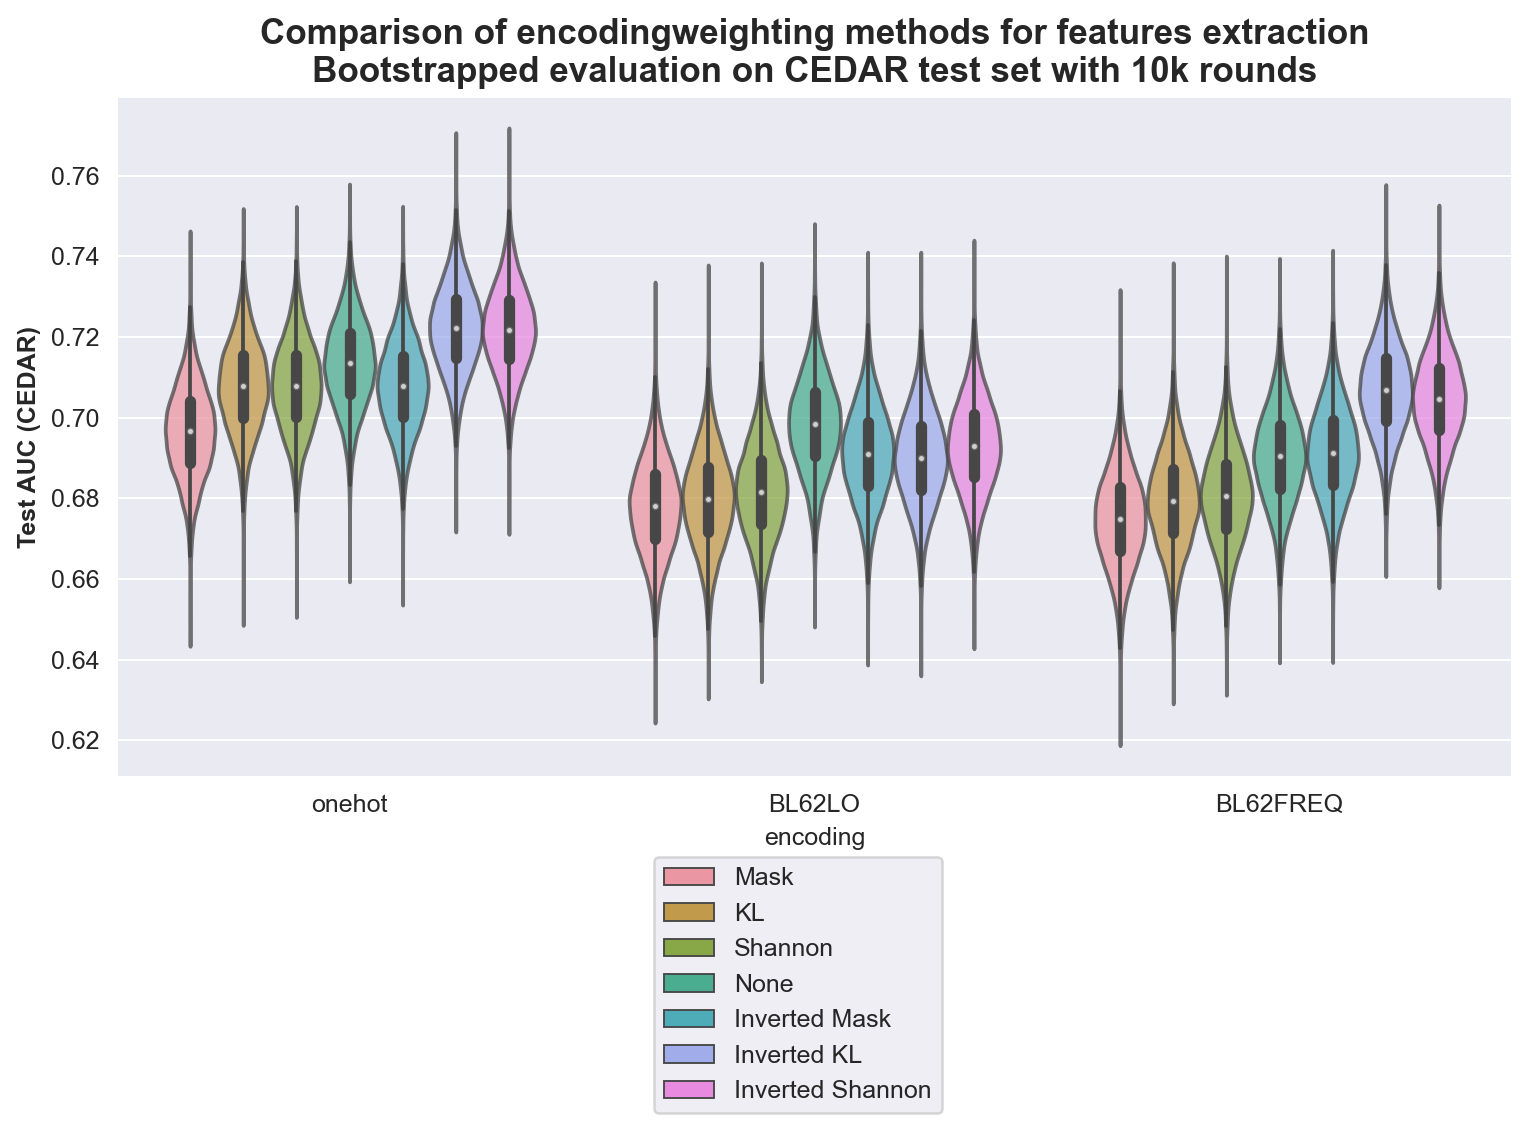

In [47]:
order = ['Mask', 'KL', 'Shannon', 'None', 'Inverted Mask', 'Inverted KL', 'Inverted Shannon']
# VIOLINPLOTS WITHOUT PRIME
f,a = plt.subplots(1,1, figsize=(10,5))
sns.set_palette(HSV)
sns.violinplot(data= df_all_weight.query('weight!="Inverted None"'), x = 'encoding', hue='weight', y = 'auc', cut=1,
               hue_order = order,
               dodge=True, width=.8, ax=a)
plt.setp(a.collections, alpha=.75)
a.set_title('Comparison of encodingweighting methods for features extraction\nBootstrapped evaluation on CEDAR test set with 10k rounds',
           fontweight='semibold', fontsize=14)
a.set_ylabel('Test AUC (CEDAR)', fontweight='semibold')
a.legend(bbox_to_anchor=(.6, -.1))
 

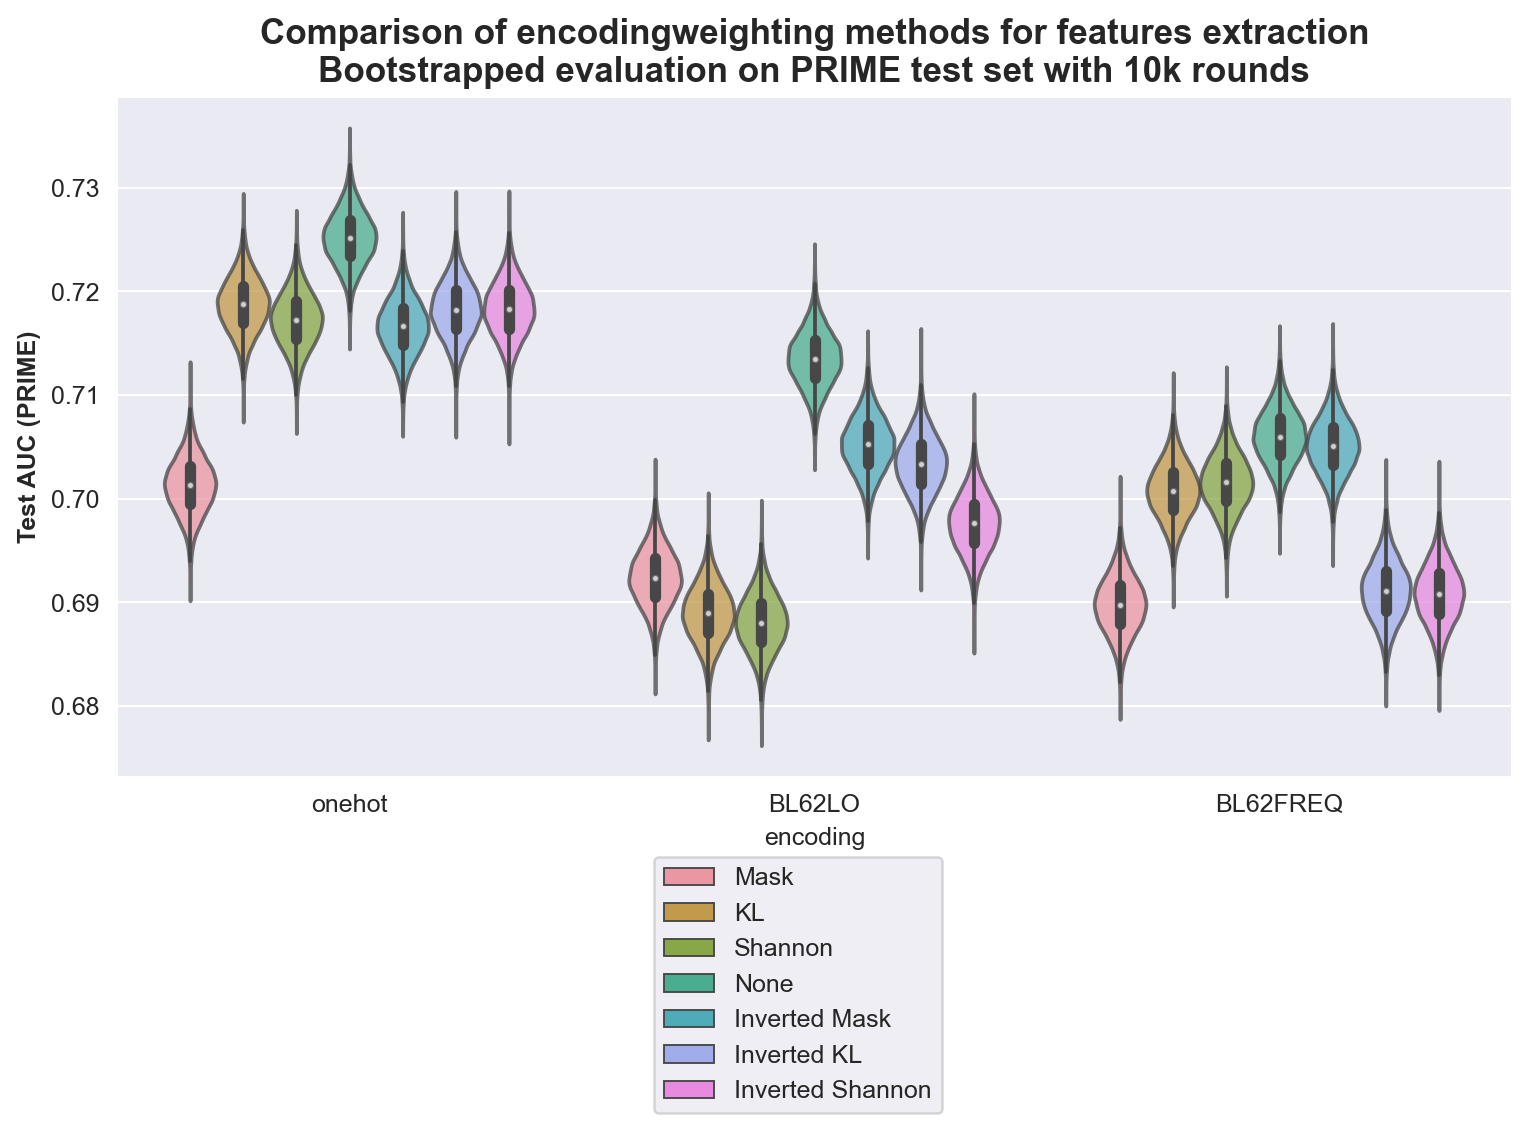

In [48]:
# VIOLINPLOTS  PRIME
f,a = plt.subplots(1,1, figsize=(10,5))
sns.set_palette(HSV)
sns.violinplot(data= df_all_weight_prime.query('weight!="Inverted None"'), x = 'encoding', hue='weight', y = 'auc', cut=1,
               hue_order = order,
               dodge=True, width=.8, ax=a)
plt.setp(a.collections, alpha=.75)
a.set_title('Comparison of encodingweighting methods for features extraction\nBootstrapped evaluation on PRIME test set with 10k rounds',
           fontweight='semibold', fontsize=14)
a.set_ylabel('Test AUC (PRIME)', fontweight='semibold')
a.legend(bbox_to_anchor=(.6, -.1))
 

In [50]:
values_normal = df_tmp.query('weight==@normal and encoding=="onehot"')['auc'].values
values_inverted = df_tmp.query('weight==@inverted and encoding=="onehot"')['auc'].values

In [51]:
len(values_normal), len(values_inverted)

(30000, 50000)

In [70]:
df_tmp = df_all_weight.query('encoding=="onehot" and (weight=="None" or weight==@normal or weight==@inverted)')
df_tmp.groupby(['encoding','weight']).agg(count=('auc','count'))

count
encoding weight                 
onehot   Inverted Shannon  50000
         None              50000
         Shannon           50000

                        count
encoding weight              
onehot   Inverted Mask  50000
         Mask           50000
         None           50000
                      count
encoding weight            
onehot   Inverted KL  50000
         KL           50000
         None         50000
                           count
encoding weight                 
onehot   Inverted Shannon  50000
         None              50000
         Shannon           50000


Text(0.5, 0.98, 'Comparison of weight vs "inverted" weight\nOn bootstrapped CEDAR test set (n=50000)')

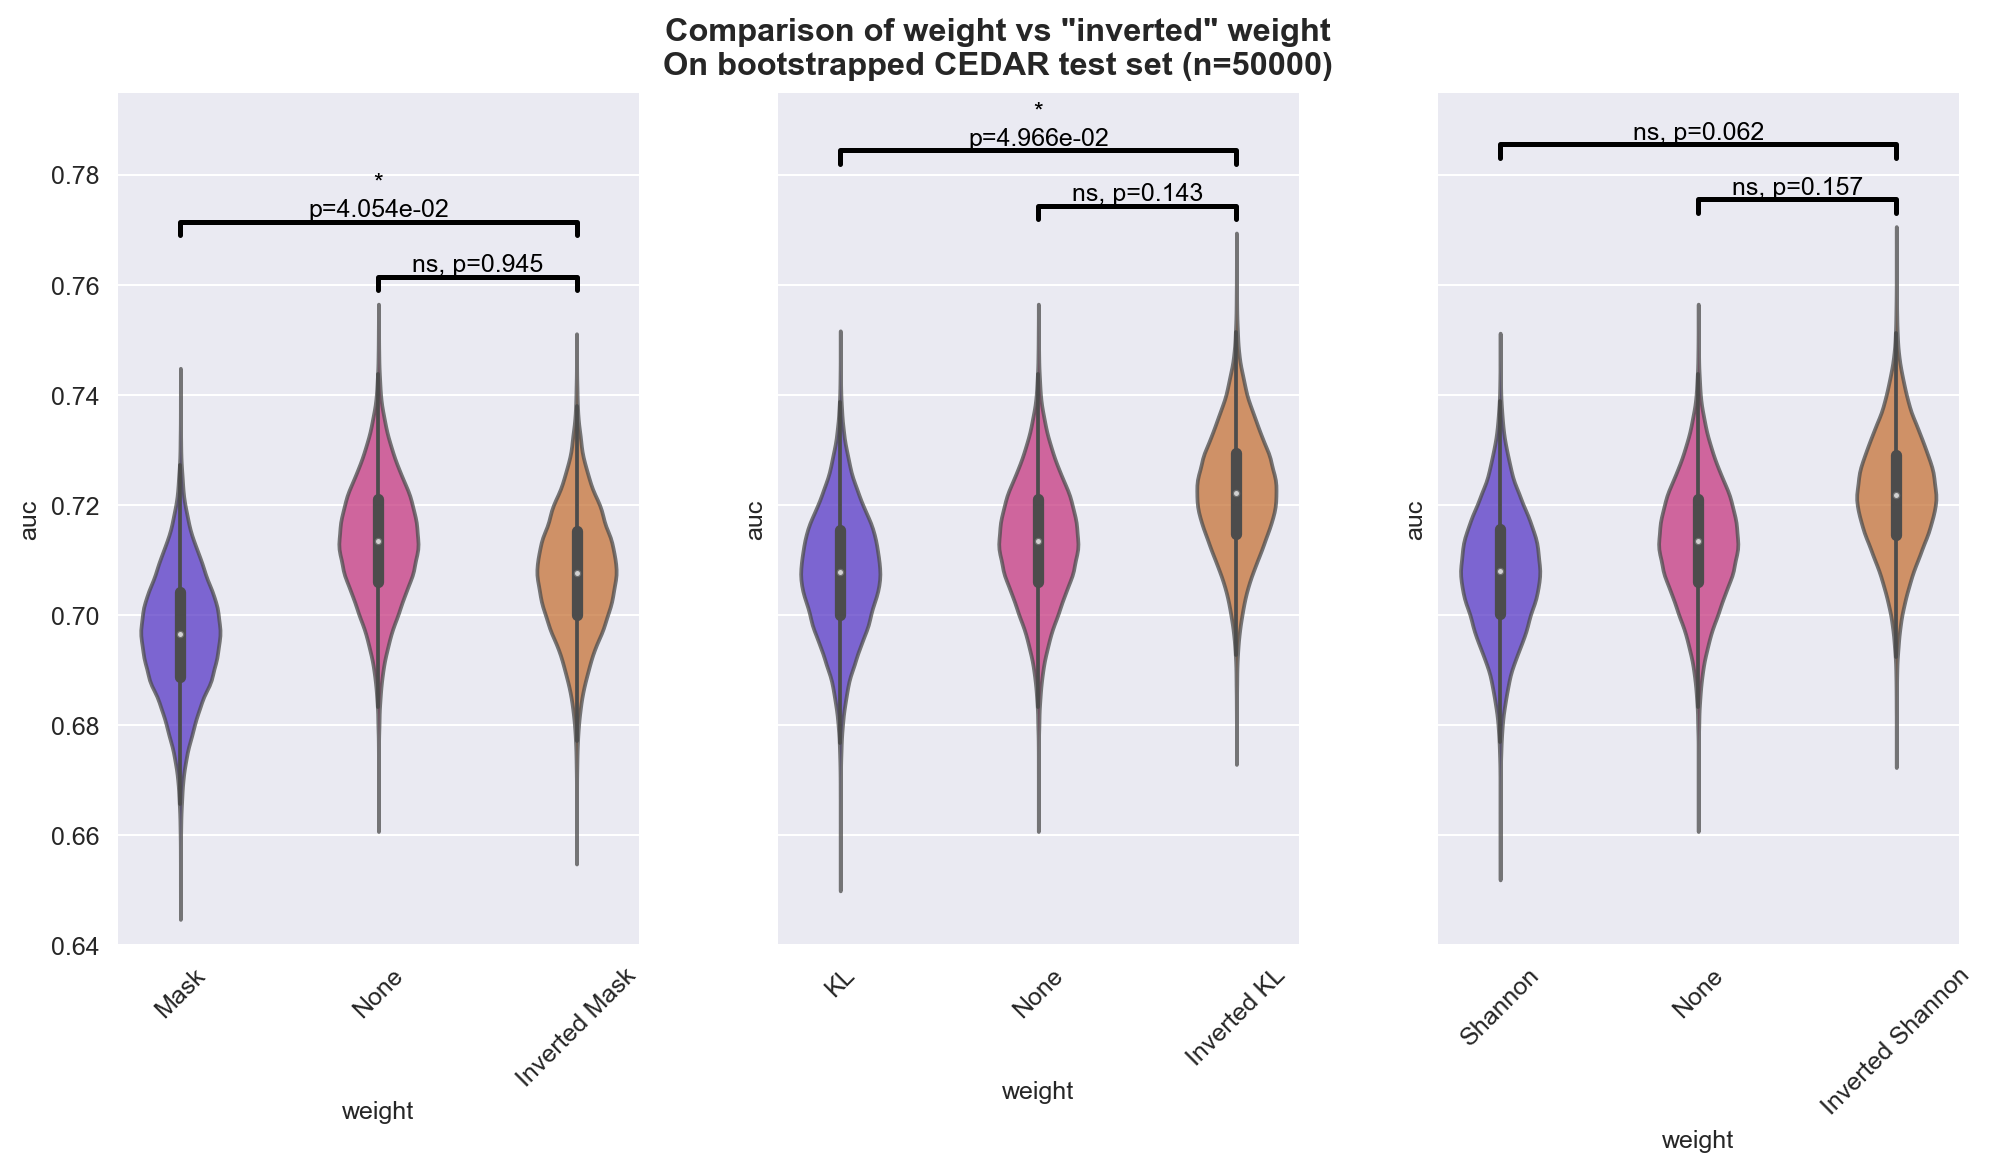

In [82]:
order = ['Mask', 'KL', 'Shannon', 'None', 'Inverted Mask', 'Inverted KL', 'Inverted Shannon']
xs = {k:v for k,v in zip(order, range(len(order)))}
pairs = [('Mask', 'Inverted Mask'),
         ('KL', 'Inverted KL'),
         ('Shannon', 'Inverted Shannon')]

# One subplot for each pair, include "None" in each pair for comparison
sns.set_palette(HSV)#, n_colors=7)
f,a = plt.subplots(1,3, figsize=(12,7), sharey=True)

#############################################################
# FIRST (left boxplot to check Add Rank on CEDAR with pval) #
#############################################################
# Preset the x values for the p-value bars centering
x_normal, x_none, x_inverted = 0, 1, 2
### P values:
values_none = df_all_weight.query('weight=="None" and encoding=="onehot"')['auc'].values
for i, (normal, inverted) in enumerate(pairs):

    df_tmp = df_all_weight.query('encoding=="onehot" and (weight=="None" or weight==@normal or weight==@inverted)').replace({'Inverted ':'Inv '})
    print(df_tmp.groupby(['encoding','weight']).agg(count=('auc','count')))
    sns.violinplot(data=df_tmp, x='weight', y='auc', hue='weight', hue_order = [normal, 'None', inverted],
                   order=[normal, 'None', inverted], ax = a[i], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
    plt.setp(a[i].collections, alpha=.75)
    a[i].legend([],[],frameon=False)
    a[i].set_ylim([.64, .795])
    a[i].set_xticklabels(a[i].get_xticklabels(), rotation=45)
    
    values_normal = df_tmp.query('weight==@normal')['auc'].values
    values_inverted = df_tmp.query('weight==@inverted')['auc'].values

    # P values that "inverted" is better than the normal
    pval_inverted_normal =  1 - (len((values_inverted>values_normal).astype(int).nonzero()[0]) / len(values_inverted))
    label_inverted_normal = f'*\np={pval_inverted_normal:.3e}' if pval_inverted_normal<0.05 else f'ns, p={pval_inverted_normal:.3f}'
    # vs none
    pval_inverted_none = 1 - (len((values_inverted>values_none).astype(int).nonzero()[0]) / len(values_inverted))
    label_inverted_none = f'*\np={pval_inverted_none:.3e}' if pval_inverted_none<0.05 else f'ns, p={pval_inverted_none:.3f}'
    
    h = 0.0025
    # Use the max_aucs thing to get top end of the plot
    max_aucs = df_tmp.groupby('weight').agg(y=('auc','max'))
    # Draw inverted-none first, as inverted-normal has to be above that anyway to not cross the bars
    y_inverted_none = max_aucs.loc[['None', inverted]].max().item()+0.0025
    y_inverted_normal = y_inverted_none + 0.01
    # Plotting inv vs none
    a[i].plot([x_none, x_none, x_inverted, x_inverted], 
              [y_inverted_none, y_inverted_none+h, y_inverted_none+h, y_inverted_none], 
              lw = 2, c='k')
    a[i].text((x_none+x_inverted)*.5, y_inverted_none+h, label_inverted_none, 
              ha = 'center', va = 'bottom', color = 'k')
    # Plotting inv vs normal
    a[i].plot([x_normal, x_normal, x_inverted, x_inverted], 
              [y_inverted_normal, y_inverted_normal+h, y_inverted_normal+h, y_inverted_normal], 
              lw = 2, c='k')
    a[i].text((x_normal+x_inverted)*.5, y_inverted_normal+h, label_inverted_normal, 
              ha = 'center', va = 'bottom', color = 'k')
f.tight_layout(pad=4)
f.suptitle('Comparison of weight vs "inverted" weight\nOn bootstrapped CEDAR test set (n=50000)', fontweight='semibold', fontsize=13)

Text(0.5, 1.0, 'Comparison of ROCs for Weights vs Inverted Weights\nBootstrapped evaluation on CEDAR test set using 30k rounds.')

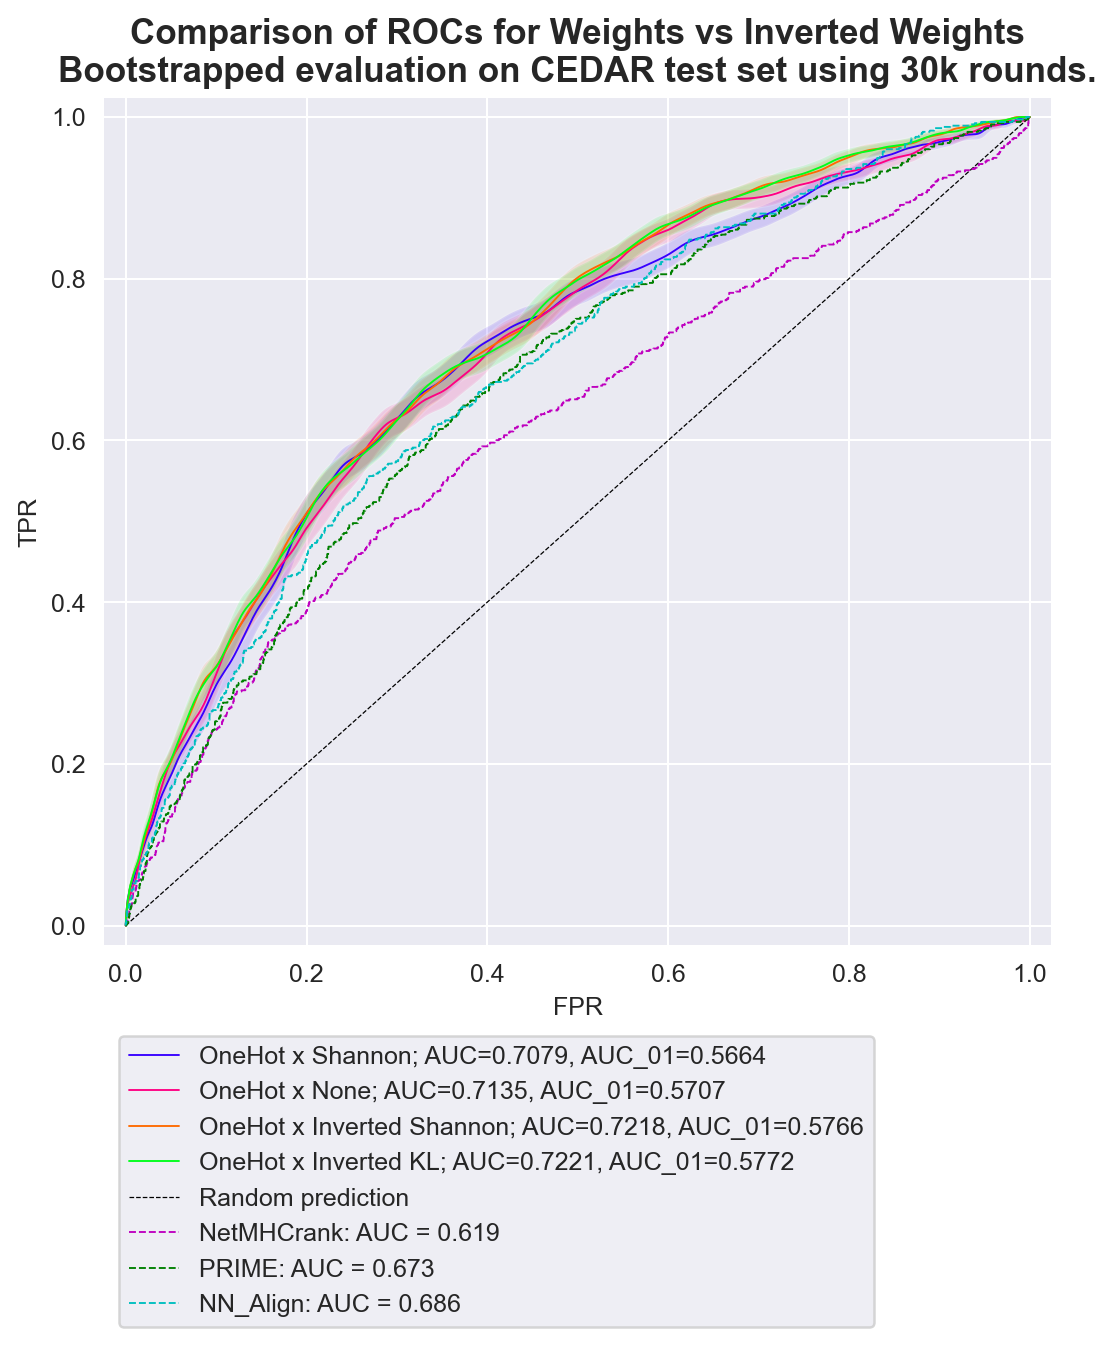

In [57]:
shannon_roc = enc_weight_results['onehot']['Shannon']['mean_rocs_cedar']
shannon_auc01 = enc_weight_results['onehot']['Shannon']['df_cedar']['auc_01'].mean()
none_roc = inverted_enc_weight_results['onehot']['None']['mean_rocs_cedar']
none_auc01 = inverted_enc_weight_results['onehot']['None']['df_cedar']['auc_01'].mean()

inverted_sh_roc = inverted_enc_weight_results['onehot']['Shannon']['mean_rocs_cedar']
inverted_sh_auc01 = inverted_enc_weight_results['onehot']['Shannon']['df_cedar']['auc_01'].mean()
inverted_kl_roc = inverted_enc_weight_results['onehot']['KL']['mean_rocs_cedar']
inverted_kl_auc01 = inverted_enc_weight_results['onehot']['KL']['df_cedar']['auc_01'].mean()
# ROC PLOT
sns.set_palette(HSV)
f,a = plt.subplots(1,1, figsize=(6,7.2))

sns.lineplot(x=shannon_roc[0],y=shannon_roc[1], ax=a, lw=0.75,
                 label = f'OneHot x Shannon; AUC={round(shannon_roc[4],4)}, AUC_01={round(shannon_auc01,4)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(shannon_roc[0])), shannon_roc[2], shannon_roc[3], alpha=0.15)
    
sns.lineplot(x=none_roc[0],y=none_roc[1], ax=a, lw=0.75,
                 label = f'OneHot x None; AUC={round(none_roc[4],4)}, AUC_01={round(none_auc01,4)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(none_roc[0])), none_roc[2], none_roc[3], alpha=0.15)


sns.lineplot(x=inverted_sh_roc[0],y=inverted_sh_roc[1], ax=a, lw=0.75,
                 label = f'OneHot x Inverted Shannon; AUC={round(inverted_sh_roc[4],4)}, AUC_01={round(inverted_sh_auc01,4)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(inverted_sh_roc[0])), inverted_sh_roc[2], inverted_sh_roc[3], alpha=0.15)
    
sns.lineplot(x=inverted_kl_roc[0],y=inverted_kl_roc[1], ax=a, lw=0.75,
                 label = f'OneHot x Inverted KL; AUC={round(inverted_kl_roc[4],4)}, AUC_01={round(inverted_kl_auc01,4)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(inverted_kl_roc[0])), inverted_kl_roc[2], inverted_kl_roc[3], alpha=0.15)


a.plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')
# a.legend(bbox_to_anchor = (1.05, .67))#
a.set_ylim([-.025,1.025])
a.set_xlim([-.025,1.025])
plot_baseline_roc(axis=a, dataset='cedar')
a.legend(bbox_to_anchor= (.825, -.091))
f.tight_layout()
a.set_xlabel('FPR')
a.set_ylabel('TPR')
a.set_title('Comparison of ROCs for Weights vs Inverted Weights\n'\
           'Bootstrapped evaluation on CEDAR test set using 30k rounds.', fontweight='semibold', fontsize=14)


Text(0.5, 1.0, 'Comparison of ROCs for Weights vs Inverted Weights\nBootstrapped evaluation on PRIME test set using 50k rounds.')

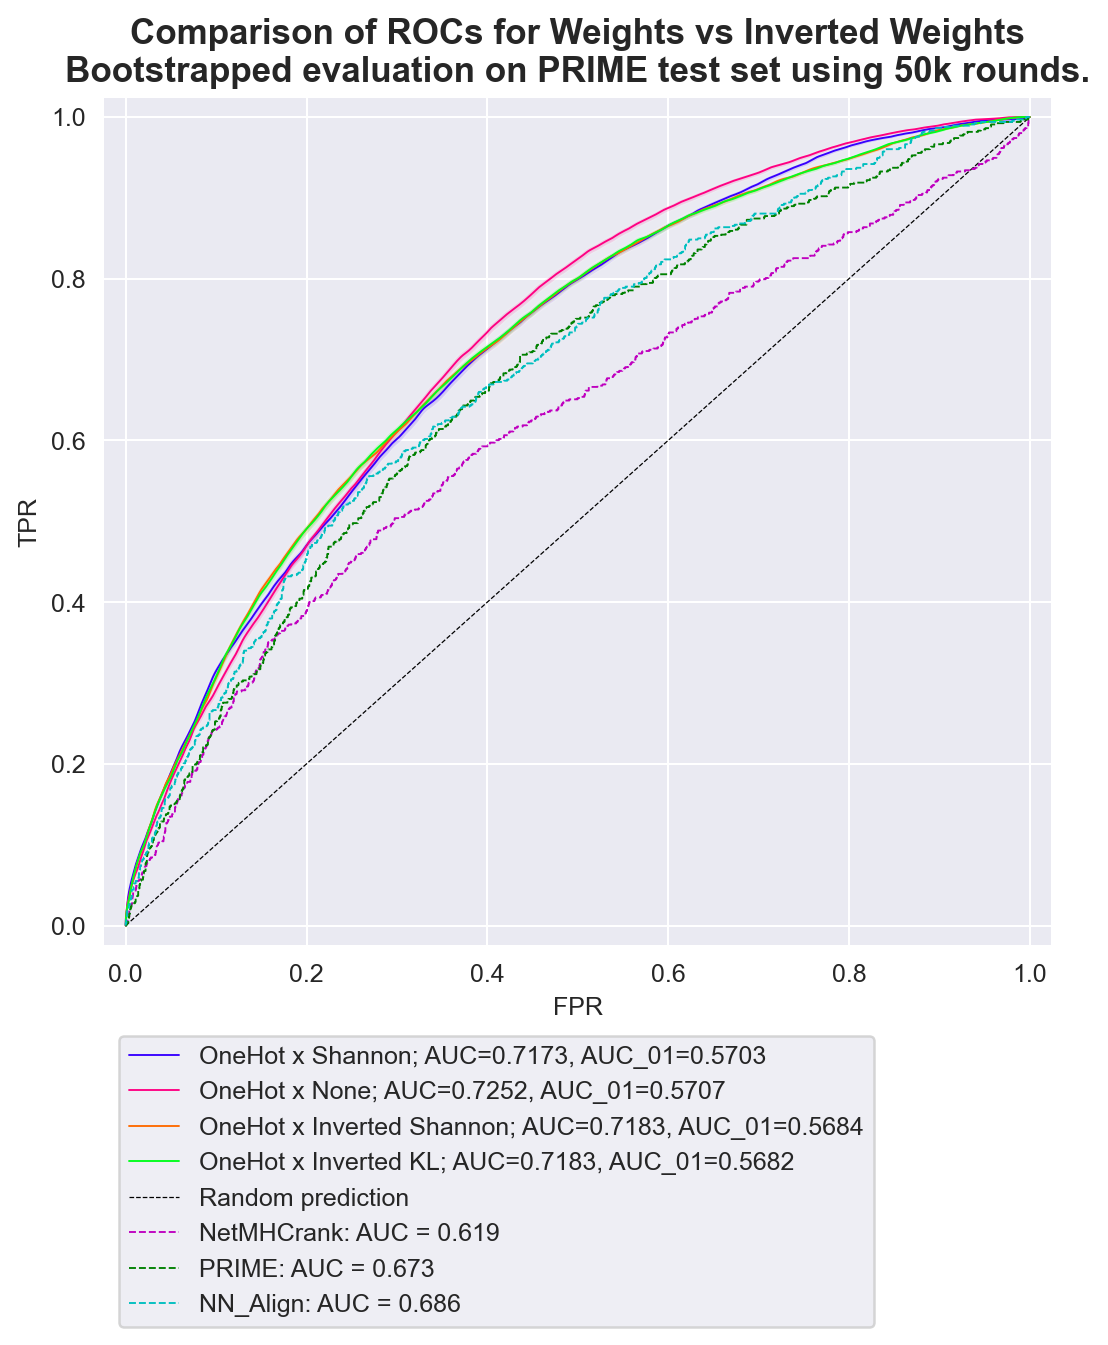

In [84]:
shannon_roc = enc_weight_results['onehot']['Shannon']['mean_rocs_prime']
shannon_auc01 = enc_weight_results['onehot']['Shannon']['df_prime']['auc_01'].mean()
none_roc = inverted_enc_weight_results['onehot']['None']['mean_rocs_prime']
none_auc01 = inverted_enc_weight_results['onehot']['None']['df_cedar']['auc_01'].mean()

inverted_sh_roc = inverted_enc_weight_results['onehot']['Shannon']['mean_rocs_prime']
inverted_sh_auc01 = inverted_enc_weight_results['onehot']['Shannon']['df_prime']['auc_01'].mean()
inverted_kl_roc = inverted_enc_weight_results['onehot']['KL']['mean_rocs_prime']
inverted_kl_auc01 = inverted_enc_weight_results['onehot']['KL']['df_prime']['auc_01'].mean()
# ROC PLOT
sns.set_palette(HSV)
f,a = plt.subplots(1,1, figsize=(6,7.2))

sns.lineplot(x=shannon_roc[0],y=shannon_roc[1], ax=a, lw=0.75,
                 label = f'OneHot x Shannon; AUC={round(shannon_roc[4],4)}, AUC_01={round(shannon_auc01,4)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(shannon_roc[0])), shannon_roc[2], shannon_roc[3], alpha=0.15)
    
sns.lineplot(x=none_roc[0],y=none_roc[1], ax=a, lw=0.75,
                 label = f'OneHot x None; AUC={round(none_roc[4],4)}, AUC_01={round(none_auc01,4)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(none_roc[0])), none_roc[2], none_roc[3], alpha=0.15)


sns.lineplot(x=inverted_sh_roc[0],y=inverted_sh_roc[1], ax=a, lw=0.75,
                 label = f'OneHot x Inverted Shannon; AUC={round(inverted_sh_roc[4],4)}, AUC_01={round(inverted_sh_auc01,4)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(inverted_sh_roc[0])), inverted_sh_roc[2], inverted_sh_roc[3], alpha=0.15)
    
sns.lineplot(x=inverted_kl_roc[0],y=inverted_kl_roc[1], ax=a, lw=0.75,
                 label = f'OneHot x Inverted KL; AUC={round(inverted_kl_roc[4],4)}, AUC_01={round(inverted_kl_auc01,4)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(inverted_kl_roc[0])), inverted_kl_roc[2], inverted_kl_roc[3], alpha=0.15)


a.plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')
# a.legend(bbox_to_anchor = (1.05, .67))#
a.set_ylim([-.025,1.025])
a.set_xlim([-.025,1.025])
plot_baseline_roc(axis=a, dataset='cedar')
a.legend(bbox_to_anchor= (.825, -.091))
f.tight_layout()
a.set_xlabel('FPR')
a.set_ylabel('TPR')
a.set_title('Comparison of ROCs for Weights vs Inverted Weights\n'\
           'Bootstrapped evaluation on PRIME test set using 50k rounds.', fontweight='semibold', fontsize=14)


## Fix evaluate to return a predictions dataframe

### TRAIN

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# TRAIN
def nested_kcv_train_tmp(dataframe, base_model, ics_dict, encoding_kwargs: dict = None):
    """
    Args:
        dataframe:
        base_model:
        ics_dict:
        encoding_kwargs:

    Returns:
        models_fold
        train_results
        test_results
    """
    if encoding_kwargs is None:
        encoding_kwargs = {'max_len': 12,
                           'encoding': 'onehot',
                           'blosum_matrix': None,
                           'standardize': False}
    essential_keys = ['max_len', 'encoding', 'blosum_matrix', 'standardize']
    assert all([x in encoding_kwargs.keys() for x in
                essential_keys]), f'Encoding kwargs don\'t contain the essential key-value pairs! ' \
                                  f"{'max_len', 'encoding', 'blosum_matrix', 'standardize'} are required."
    models_dict = {}
    test_metrics = {}
    train_metrics = {}
    folds = sorted(dataframe.fold.unique())
    # if mode == 'train':
    seed = 0
    for fold_out in tqdm(folds, leave=False, desc='Outer fold', position=2):
        # Get test set & init models list to house all models trained in inner fold
        test = dataframe.query('fold == @fold_out').reset_index(drop=True)
        x_test_base, y_test = get_array_dataset(test, ics_dict, **encoding_kwargs)
        train_metrics[fold_out] = {}
        # For a given fold, all the models that are trained should be appended to this list
        models_dict[fold_out] = []
        avg_prediction = []
        for fold_in in tqdm(sorted([f for f in folds if f != fold_out]), leave=False, desc='Inner fold'):
            # Copy the base model, resets the seed
            model = sklearn.base.clone(base_model)
            model.set_params(random_state=seed)
            if encoding_kwargs['standardize']:
                model = Pipeline([('scaler', StandardScaler()), ('model', model)])
            # Create the sub-dict and put the model into the models dict
            train_metrics[fold_out][fold_in] = {}
            # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
            # Query subset dataframe and get encoded data and targets
            train = dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
            valid = dataframe.query('fold == @fold_in').reset_index(drop=True)
            # Get datasets
            x_train, y_train = get_array_dataset(train, ics_dict, **encoding_kwargs)
            x_valid, y_valid = get_array_dataset(valid, ics_dict, **encoding_kwargs)
            x_test, y_test = get_array_dataset(test, ics_dict, **encoding_kwargs)
            
            # Fit the model and append it to the list
            model.fit(x_train, y_train)
            models_dict[fold_out].append(model)
            # Get the prediction values on both the train and validation set
            y_train_pred, y_train_score = model.predict(x_train), model.predict_proba(x_train)[:, 1]
            y_val_pred, y_val_score = model.predict(x_valid), model.predict_proba(x_valid)[:, 1]
            # Get the metrics and save them
            train_metrics[fold_out][fold_in]['train'] = get_metrics(y_train, y_train_score, y_train_pred)
            train_metrics[fold_out][fold_in]['valid'] = get_metrics(y_valid, y_val_score, y_val_pred)

            # seed increment
            seed += 1
            avg_prediction.append(model.predict_proba(x_test)[:, 1])
        # Evaluate on test set
        avg_prediction = np.mean(np.stack(avg_prediction), axis=0)
        test_metrics[fold_out] = get_metrics(y_test, avg_prediction)

    return models_dict, train_metrics, test_metrics

### eval

In [40]:
# EVAL
def evaluate_trained_models_tmp(test_dataframe, models_dict, ics_dict,
                                    train_dataframe=None, train_metrics=None,
                                    encoding_kwargs: dict = None,
                                    concatenated=False, only_concat=False, keep=False,
                                    return_scores = False):
    """

    Args:
        dataframe:
        models_dict:
        ics_dict:
        train_metrics (dict): Should be used if standardize in encoding_kwargs is True...
        encoding_kwargs:
        concatenated:
        only_concat:

    Returns:
        test_results
        concat_pred (if return_scores==True)
        concat_true (if return_scores==True)
    """
    if encoding_kwargs is None:
        encoding_kwargs = {'max_len': 12,
                           'encoding': 'onehot',
                           'blosum_matrix': BL62_VALUES,
                           'standardize': False,
                           'seq_col': 'Peptide',
                           'hla_col': 'HLA',
                           'target_col': 'agg_label',
                           'rank_col': 'trueHLA_EL_rank'}
    # This garbage code makes me want to cry
    if any([(x not in encoding_kwargs.keys()) for x in ['seq_col', 'hla_col', 'target_col', 'rank_col']]):
        encoding_kwargs = copy.deepcopy(encoding_kwargs)
        encoding_kwargs.update({'seq_col': 'Peptide',
                                'hla_col': 'HLA',
                                'target_col': 'agg_label',
                                'rank_col': 'trueHLA_EL_rank'})

    essential_keys = ['max_len', 'encoding', 'blosum_matrix', 'standardize']
    assert all([x in encoding_kwargs.keys() for x in
                essential_keys]), f'Encoding kwargs don\'t contain the essential key-value pairs! ' \
                                  f"{'max_len', 'encoding', 'blosum_matrix', 'standardize'} are required."

    # if encoding_kwargs['standardize'] and train_metrics is None:
    #     raise ValueError('Standardize is enabled but no train_metrics provided!' \
    #                      ' The mu and sigma of each fold is needed to standardize the test set!')
    test_results = {}
    if concatenated:
        concat_pred = []
        concat_true = []
    preds_df = []
    for fold_out, models_list_out in models_dict.items():
        # If no train dataframe provided and test_dataframe is partitioned,
        # It will eval on each of the folds
        if 'fold' in test_dataframe.columns:
            if test_dataframe.equals(train_dataframe):
                test_df = test_dataframe.query('fold==@fold_out')
            else:
                test_df = test_dataframe.copy().reset_index(drop=True)
        else:
            test_df = test_dataframe.copy().reset_index(drop=True)
        x_test, y_test = get_array_dataset(test_df, ics_dict, **encoding_kwargs)
        # Fuck my life ; Here to make sure the test fold evaluated doesn't overlap with with training peptides
        inner_folds = [x for x in range(len(models_dict.keys())) if x != fold_out]
        # TODO One of the worst garbage code (top 5) I've written this week
        # TODO Actually after coming back this is TOP 1 GARBAGE
        if train_dataframe is not None and not train_dataframe.equals(test_dataframe):
            tmp = train_dataframe.query('fold != @fold_out')  # Not sure why but I need to add this or it breaks
            train_peps = [tmp.query('fold!=@fold_in')[encoding_kwargs['seq_col']].values for fold_in in inner_folds]
            tmp_index = [test_df.query('Peptide not in @peps').index for peps in train_peps]
            index_keep = tmp_index[0]
            for index in tmp_index[1:]:
                index_keep = index_keep.join(index, how='inner')
            # Fixes the issue with indexing length when verify_df in get_array_dataset removes some
            index_keep = [x for x in index_keep if x in range(len(x_test))]

        else:
            index_keep = range(len(x_test))
        # test_df = test_df.loc[index_keep]
        x_test = x_test[index_keep]
        avg_prediction = [model.predict_proba(x_test)[:, 1] for i, model in
                              enumerate(models_list_out)]
        avg_prediction = np.mean(np.stack(avg_prediction), axis=0)
        test_results[fold_out] = get_metrics(y_test[index_keep], avg_prediction, keep=keep)

        # test_df['prediction_score'] = avg_prediction
        # preds_df.append(test_df)
        if concatenated:
            concat_pred.append(avg_prediction)
            concat_true.append(y_test[index_keep])
    # Here get the mean results

    if concatenated:
        # "PRED" HERE IS ACTUALLY THE SCORES
        concat_pred = np.concatenate(concat_pred)
        concat_true = np.concatenate(concat_true)
        test_results['concatenated'] = get_metrics(concat_true, concat_pred, keep=keep)

    if only_concat:
        keys_del = [k for k in test_results if k != 'concatenated']
        for k in keys_del:
            del test_results[k]

    if return_scores and concatenated:
        # preds_df = pd.concat(preds_df).sort_values('Peptide')
        # all_cols = [x for x in preds_df.columns if x != 'prediction_score']
        # preds_df.groupby(all_cols).agg(mean_pred=('prediction_score', 'mean')).reset_index()
        # return test_results,  preds_df# concat_pred, concat_true
        return test_results, concat_pred, concat_true# preds_df  # concat_pred, concat_true

    else:
        return test_results

### xd

In [45]:
import copy
kwargs = {'max_len': 12,
          'encoding': 'onehot',
          'blosum_matrix': None,
          'mask': False,
          'invert': False,
          'add_rank': True,
          'add_aaprop': False,
          'remove_pep': False,
          'standardize': True}

In [46]:
old_models, old_metrics, _  = nested_kcv_train_sklearn(cedar, RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=1),
                         None, kwargs)
old_results, old_pred, old_true = evaluate_trained_models_sklearn(cedar, old_models, None,
                                                                     train_dataframe=cedar,
                                                                     train_metrics=old_metrics,
                                                                     encoding_kwargs=kwargs,
                                                                     concatenated=True,
                                                                     only_concat=False, keep=True,
                                                                     return_scores=True)

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [47]:
debug_models, debug_metrics, _  = nested_kcv_train_tmp(cedar, RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=1),
                         None, kwargs)
debug_results, debug_pred, debug_true = evaluate_trained_models_tmp(cedar, debug_models, None,
                                                                     train_dataframe=cedar,
                                                                     train_metrics=None,
                                                                     encoding_kwargs=kwargs,
                                                                     concatenated=True,
                                                                     only_concat=False, keep=True,
                                                                     return_scores=True)

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
old_results['concatenated']['auc'], debug_results['concatenated']['auc']

(0.6997444788305288, 0.6997444788305288)

In [49]:
pkl_dump(debug_models, 'models.pkl', '../data/debug/')
pkl_dump(kwargs, 'kwargs.pkl', '../data/debug/')

../data/debug/models.pkl saved.
../data/debug/kwargs.pkl saved.


In [78]:
for k in kwargs:
    print(k)

max_len
encoding
blosum_matrix
mask
invert
add_rank
add_aaprop
remove_pep
standardize


In [81]:
from src.train_eval import get_predictions
preds_df = get_predictions(cedar, debug_models[0], None, kwargs)
preds_df2 = preds_df.copy()
preds_df2['pred'] = preds_df2['pred'].apply(lambda x: x-(x*np.random.normal()))

(3480, 21)
9


In [83]:
concat = pd.concat([preds_df, preds_df2])

In [84]:
preds_df

Unnamed: 0      Peptide         HLA  trueHLA_EL_rank  agg_label  fold  \
0              0  AAAAAAQQIQV  HLA-B07:02          26.7692          0     8   
1              1    AAAAQQIQV  HLA-B07:02           4.9092          0     8   
2              2    AAAAQQIQV  HLA-A02:01           1.9555          0     8   
3              3    AAFIWIISM  HLA-B35:01           1.3004          0     9   
4              4    AAHFTVLLY  HLA-A11:01           0.4196          0     3   
...          ...          ...         ...              ...        ...   ...   
3475        3475    YYPGKKEPF  HLA-A24:02           0.0965          0     5   
3476        3476   YYPPSQIAQL  HLA-A24:02           0.0566          1     2   
3477        3477    YYSKNLNSF  HLA-A24:02           0.0033          1     6   
3478        3478   YYSKNLNSFF  HLA-A24:02           0.0310          1     8   
3479        3479    YYSPQAQTL  HLA-A24:02           0.0052          0     1   

      BA_rank  BA_score              PMIDs       core        icore     label  \
0     11.9024    0.1632           27198675  AAAAAQIQV  AAAAAAQQIQV  Negative   
1      0.3045    0.4709           27198675  AAAAQQIQV    AAAAQQIQV  Negative   
2      0.3045    0.4709           27198675  AAAAQQIQV    AAAAQQIQV  Negative   
3      0.1502    0.6560           27198675  AAFIWIISM    AAFIWIISM  Negative   
4      0.1083    0.6509           31511069  AAHFTVLLY    AAHFTVLLY  Negative   
...       ...       ...                ...        ...          ...       ...   
3475   0.0750    0.7654  34270940,34270940  YYPGKKEPF    YYPGKKEPF  Negative   
3476   0.0780    0.7614           26048577  YYPPSQIAL   YYPPSQIAQL  Positive   
3477   0.0086    0.8124           28423700  YYSKNLNSF    YYSKNLNSF  Positive   
3478   0.0122    0.7758  28423700,28423700  YYSKNLNSF   YYSKNLNSFF  Positive   
3479   0.0088    0.8825           30880120  YYSPQAQTL    YYSPQAQTL  Negative   

      len  percentage_pos  pred_EL_rank  pred_EL_score    pred_HLA  \
0      11             0.0        5.2822         0.0166  HLA-A68:02   
1       9             0.0        0.1036         0.6567  HLA-C15:02   
2       9             0.0        0.1036         0.6567  HLA-C15:02   
3       9             0.0        0.1756         0.3961  HLA-C12:03   
4       9             0.0        0.0256         0.8170  HLA-A30:02   
...   ...             ...           ...            ...         ...   
3475    9             0.0        0.0301         0.9052  HLA-C14:02   
3476   10             1.0        0.0418         0.8745  HLA-C14:02   
3477    9             1.0        0.0033         0.9896  HLA-A24:02   
3478   10             1.0        0.0310         0.9225  HLA-A24:02   
3479    9             0.0        0.0021         0.9916  HLA-C14:02   

                      responses  total_count  aliphatic_index     boman  \
0                      Negative            1       116.363636 -0.290909   
1                      Negative            1       120.000000  0.046667   
2                      Negative            1       120.000000  0.046667   
3                      Negative            1       152.222222 -2.515556   
4                      Negative            1       141.111111 -1.456667   
...                         ...          ...              ...       ...   
3475          Negative,Negative            2         0.000000  1.585556   
3476               Positive_all            1        88.000000  0.311000   
3477               Positive_all            1        43.333333  2.001111   
3478  Positive_all,Positive_all            2        39.000000  1.503000   
3479                   Negative            1        54.444444  1.177778   

      hydrophobicity  isoelectric_point     VHSE1     VHSE3     VHSE7  \
0           0.818182           6.100000  0.004545 -0.675455  0.105455   
1           0.600000           6.100000 -0.027778 -0.525556  0.048889   
2           0.600000           6.100000 -0.027778 -0.525556  0.048889   
3           2.233333           6.100000  0.830000  0.034444 -0

In [87]:
display(preds_df[['Peptide', 'HLA', 'pred']].head(3))
display(preds_df2[['Peptide', 'HLA', 'pred']].head(3))

Peptide         HLA      pred
0  AAAAAAQQIQV  HLA-B07:02  0.147260
1    AAAAQQIQV  HLA-B07:02  0.161248
2    AAAAQQIQV  HLA-A02:01  0.161326

Peptide         HLA      pred
0  AAAAAAQQIQV  HLA-B07:02  0.130536
1    AAAAQQIQV  HLA-B07:02  0.099462
2    AAAAQQIQV  HLA-A02:01 -0.124007

In [93]:
cedar.merge(concat.groupby(['Peptide', 'HLA', 'agg_label', 'trueHLA_EL_rank']).agg(mean_pred = ('pred', 'mean')).reset_index(),
            left_on=['Peptide', 'HLA', 'agg_label', 'trueHLA_EL_rank'], right_on = ['Peptide', 'HLA', 'agg_label', 'trueHLA_EL_rank'], suffixes=[None,None])

Unnamed: 0      Peptide         HLA  trueHLA_EL_rank  agg_label  fold  \
0              0  AAAAAAQQIQV  HLA-B07:02          26.7692          0     8   
1              1    AAAAQQIQV  HLA-B07:02           4.9092          0     8   
2              2    AAAAQQIQV  HLA-A02:01           1.9555          0     8   
3              3    AAFIWIISM  HLA-B35:01           1.3004          0     9   
4              4    AAHFTVLLY  HLA-A11:01           0.4196          0     3   
...          ...          ...         ...              ...        ...   ...   
3475        3475    YYPGKKEPF  HLA-A24:02           0.0965          0     5   
3476        3476   YYPPSQIAQL  HLA-A24:02           0.0566          1     2   
3477        3477    YYSKNLNSF  HLA-A24:02           0.0033          1     6   
3478        3478   YYSKNLNSFF  HLA-A24:02           0.0310          1     8   
3479        3479    YYSPQAQTL  HLA-A24:02           0.0052          0     1   

      BA_rank  BA_score              PMIDs       core        icore     label  \
0     11.9024    0.1632           27198675  AAAAAQIQV  AAAAAAQQIQV  Negative   
1      0.3045    0.4709           27198675  AAAAQQIQV    AAAAQQIQV  Negative   
2      0.3045    0.4709           27198675  AAAAQQIQV    AAAAQQIQV  Negative   
3      0.1502    0.6560           27198675  AAFIWIISM    AAFIWIISM  Negative   
4      0.1083    0.6509           31511069  AAHFTVLLY    AAHFTVLLY  Negative   
...       ...       ...                ...        ...          ...       ...   
3475   0.0750    0.7654  34270940,34270940  YYPGKKEPF    YYPGKKEPF  Negative   
3476   0.0780    0.7614           26048577  YYPPSQIAL   YYPPSQIAQL  Positive   
3477   0.0086    0.8124           28423700  YYSKNLNSF    YYSKNLNSF  Positive   
3478   0.0122    0.7758  28423700,28423700  YYSKNLNSF   YYSKNLNSFF  Positive   
3479   0.0088    0.8825           30880120  YYSPQAQTL    YYSPQAQTL  Negative   

      len  percentage_pos  pred_EL_rank  pred_EL_score    pred_HLA  \
0      11             0.0        5.2822         0.0166  HLA-A68:02   
1       9             0.0        0.1036         0.6567  HLA-C15:02   
2       9             0.0        0.1036         0.6567  HLA-C15:02   
3       9             0.0        0.1756         0.3961  HLA-C12:03   
4       9             0.0        0.0256         0.8170  HLA-A30:02   
...   ...             ...           ...            ...         ...   
3475    9             0.0        0.0301         0.9052  HLA-C14:02   
3476   10             1.0        0.0418         0.8745  HLA-C14:02   
3477    9             1.0        0.0033         0.9896  HLA-A24:02   
3478   10             1.0        0.0310         0.9225  HLA-A24:02   
3479    9             0.0        0.0021         0.9916  HLA-C14:02   

                      responses  total_count  aliphatic_index     boman  \
0                      Negative            1       116.363636 -0.290909   
1                      Negative            1       120.000000  0.046667   
2                      Negative            1       120.000000  0.046667   
3                      Negative            1       152.222222 -2.515556   
4                      Negative            1       141.111111 -1.456667   
...                         ...          ...              ...       ...   
3475          Negative,Negative            2         0.000000  1.585556   
3476               Positive_all            1        88.000000  0.311000   
3477               Positive_all            1        43.333333  2.001111   
3478  Positive_all,Positive_all            2        39.000000  1.503000   
3479                   Negative            1        54.444444  1.177778   

      hydrophobicity  isoelectric_point     VHSE1     VHSE3     VHSE7  \
0           0.818182           6.100000  0.004545 -0.675455  0.105455   
1           0.600000           6.100000 -0.027778 -0.525556  0.048889   
2           0.600000           6.100000 -0.027778 -0.525556  0.048889   
3           2.233333           6.100000  0.830000  0.034444 -0

In [120]:
tmp_train = cedar.query('fold!=0')
tmp_test = cedar.query('fold==0')
inner_folds = [x for x in range(10) if x != 0]
train_peps = np.unique(np.concatenate([tmp_train.query('fold!=@fold_in')['Peptide'].values for fold_in in inner_folds]))
xd = tmp_train.Peptide.unique()
all(train_peps==xd)

True